# Brownian Motion Diffusion Analysis --- CORRECTED Calibration
> Ahilan Kumaresan | PHYS 382 Advanced Lab | February 2026

This code has been built with ideas inspired by the Reference code the Prof has in Canvas, along with using an LLM.

_Analysis of multiple bead sizes for diffusion coefficient comparison_

This notebook performs complete diffusion analysis including:
1. Loading MTrack2 data for multiple bead sizes
2. Track splitting at large jumps (preserves more data)
3. Displacement histogram and Gaussian fitting with chi-squared goodness-of-fit
4. Direct calculation of diffusion coefficient from variance
5. Mean-Squared Displacement (MSD) analysis with residual plots
6. **Calibration correction**: re-analysis with correct pixel size (68.4 nm/px)
7. **Comparison**: wrong vs correct calibration side by side
8. **Uncertainty analysis**: random and systematic errors
9. Quantitative comparison with Stokes-Einstein theory

---
## Calibration Correction

### The Problem

The original `Diffusion_Analysis.ipynb` used **PIXEL_SIZE = 0.345 um/px** (345 nm/px). This value was incorrectly carried over from a different objective/magnification setting. The measured diffusion coefficients were **20--40x higher** than Stokes-Einstein predictions.

### Root Cause

The correct pixel calibration, confirmed independently in **Session 1** (stage micrometer at 100x) and verified in **Session 3** (repeat calibration), is:

$$\text{PIXEL\_SIZE} = 68.45 \text{ nm/px} = 0.0684 \text{ um/px}$$

The wrong value (345 nm/px) is exactly **5.04x** larger than the correct value (68.4 nm/px).

### Why D Was Inflated

The diffusion coefficient $D$ is computed from:
$$D = \frac{\langle \Delta x^2 \rangle}{2 \Delta t}$$

where $\langle \Delta x^2 \rangle$ is in physical units ($\mu\text{m}^2$). Since the raw data is in **pixels**, the conversion is:
$$\langle \Delta x^2 \rangle_{\mu m^2} = \langle \Delta x^2 \rangle_{px^2} \times (\text{PIXEL\_SIZE})^2$$

Therefore $D \propto (\text{PIXEL\_SIZE})^2$. Using the wrong pixel size:
$$\frac{D_{\text{wrong}}}{D_{\text{correct}}} = \left(\frac{0.345}{0.0684}\right)^2 = (5.04)^2 \approx 25.4$$

This quantitatively explains the 20--40x inflation observed in the original analysis.

### This Notebook

This corrected notebook:
1. Reruns the **identical** analysis pipeline with PIXEL_SIZE = 0.0684 um/px
2. Shows side-by-side comparison of wrong vs correct results
3. Adds proper uncertainty analysis and goodness-of-fit statistics
4. Adds residual plots for all fits
5. Exports publication-quality figures to `Analysis/figures/`

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.stats import chi2 as chi2_dist
from numpy import pi, exp, sqrt
import os
import warnings
warnings.filterwarnings('ignore')

# Figure output directory
FIGURES_DIR = 'figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

# Matplotlib defaults for publication-quality figures
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'legend.fontsize': 9,
    'figure.figsize': (10, 6),
    'savefig.bbox': 'tight',
})

print('Libraries loaded. Figures will be saved to:', os.path.abspath(FIGURES_DIR))

Libraries loaded. Figures will be saved to: D:\Documents\SFU\PHYS382-AdvancedLab\phys332w-sfu-GIT\phys332W-sfu\Lab2-Microscopy-and-Motility\Analysis\figures


In [2]:
# ============================================================================
# CONTROL VARIABLES - MODIFY THESE BEFORE RUNNING
# ============================================================================

# Data file paths for each bead size
DATA_FILES = {
    1.0: '../Data/2026-02-05/1mu-21c-1isto224w-0_5p-trackresults.txt',   # 1 micron beads
    5.0: '../Data/2026-02-05/5mu-21c-1isto6_5w-0_5p-trackresults.txt',   # 5 micron beads
}

# Track selection parameters
NUM_BEST_SEGMENTS = 10    # Number of best track segments to use (ranked by length)
MIN_TRACK_LENGTH = 20     # Minimum track segment length required (frames)
SUBTRACT_DRIFT = True     # Whether to subtract mean displacement (removes drift)
MAX_DISPLACEMENT_PER_FRAME = 20  # pixels - tracks split at jumps larger than this

# === Experimental Parameters ===
FRAME_RATE = 226          # fps (frames per second)

# CORRECTED pixel size: 68.4 nm/px (confirmed Sessions 1 and 3)
PIXEL_SIZE = 0.0684       # microns per pixel  <<< CORRECTED (was 0.345)
PIXEL_SIZE_WRONG = 0.345  # the OLD incorrect value, kept for comparison

TEMPERATURE = 294.15      # Kelvin (21.0 C)
VISCOSITY = 0.0009764     # Pa.s (water at 21 C)

# Physical constants
k_B = 1.381e-23           # Boltzmann constant (J/K)

# ============================================================================
print('CONTROL VARIABLES SET')
print(f'  Data files: {len(DATA_FILES)} bead sizes')
for d, path in DATA_FILES.items():
    print(f'    {d} um: {path.split("/")[-1]}')
print(f'  Using top {NUM_BEST_SEGMENTS} track segments')
print(f'  Min track length: {MIN_TRACK_LENGTH} frames')
print(f'  Track split threshold: {MAX_DISPLACEMENT_PER_FRAME} px/frame')
print(f'  Drift correction: {"ON" if SUBTRACT_DRIFT else "OFF"}')
print()
print('Experimental parameters:')
print(f'  Frame rate: {FRAME_RATE} fps')
print(f'  PIXEL_SIZE (CORRECTED): {PIXEL_SIZE*1000:.1f} nm/px  = {PIXEL_SIZE} um/px')
print(f'  PIXEL_SIZE (old/wrong):  {PIXEL_SIZE_WRONG*1000:.1f} nm/px')
print(f'  Scale factor: {(PIXEL_SIZE_WRONG/PIXEL_SIZE)**2:.1f}x in D')
print(f'  Temperature: {TEMPERATURE} K ({TEMPERATURE-273.15:.1f} C)')
print(f'  Viscosity: {VISCOSITY} Pa.s')

CONTROL VARIABLES SET
  Data files: 2 bead sizes
    1.0 um: 1mu-21c-1isto224w-0_5p-trackresults.txt
    5.0 um: 5mu-21c-1isto6_5w-0_5p-trackresults.txt
  Using top 10 track segments
  Min track length: 20 frames
  Track split threshold: 20 px/frame
  Drift correction: ON

Experimental parameters:
  Frame rate: 226 fps
  PIXEL_SIZE (CORRECTED): 68.4 nm/px  = 0.0684 um/px
  PIXEL_SIZE (old/wrong):  345.0 nm/px
  Scale factor: 25.4x in D
  Temperature: 294.15 K (21.0 C)
  Viscosity: 0.0009764 Pa.s


## Helper Functions

Functions for loading data, splitting tracks at jumps, and performing analysis.

> **Source:** Data loading adapted from `LabLevel References/Reference-code/Python demos/MTrack2Loader.ipynb` (Rev11 250919 DAL, Physics SFU). Modified: fixed dtype bug (`np.int` -> `int`), added `invalid_raise=False`. Track splitting logic added to preserve more data by splitting at large jumps instead of discarding.

In [3]:
def load_mtrack2_data(file_path):
    """
    Load MTrack2 output file and return cleaned data matrix.
    
    Returns:
        data: numpy array with shape (frames, 2*particles) containing X,Y pairs
    """
    my_data = np.genfromtxt(file_path, delimiter='\t', skip_header=2,
                           skip_footer=1, invalid_raise=False)
    
    # Remove indexer, summary box and Flags column
    A = np.zeros(my_data.shape[1]//3+1, dtype=int)
    for i in range(my_data.shape[1]//3+1):
        A[i] = 3*i
    new_data = np.delete(my_data, A, axis=1)
    
    # Sort data - move NaN values to the end
    mask = np.isnan(new_data)
    new_mask = np.zeros(mask.shape)
    for ind, value in enumerate(mask):
        new_mask[ind, :] = ~value * (ind + 1)
    new_mask = new_mask.astype(np.int_)
    
    for row_index, row in enumerate(new_mask):
        for col_index, item in enumerate(row):
            if item == 0:
                new_mask[row_index][col_index] = (new_mask.shape[0] + 5)
    
    for i in range(new_mask.shape[1]):
        new_mask[:, i] = np.sort(new_mask[:, i])
    
    data = np.empty((mask.shape[0], mask.shape[1]))
    data[:, :] = np.nan
    
    for i in range(new_mask.shape[0]):
        for j in range(new_mask.shape[1]):
            temp = new_mask[i, j]
            if temp < (new_mask.shape[0]):
                data[i, j] = new_data[temp, j]
    
    return data


def split_tracks_at_jumps(data, min_length, max_jump_px):
    """
    Extract valid trajectory segments from raw data.
    SPLITS tracks at large jumps (tracking errors) instead of discarding entire tracks.
    
    Parameters:
        data: Raw X,Y data (rows=frames, columns=X1,Y1,X2,Y2,...)
        min_length: Minimum number of points for a valid segment
        max_jump_px: Maximum allowed jump per frame (pixels) - tracks split here
    
    Returns:
        List of trajectory dicts with 'x', 'y', 'id' keys
    """
    segments = []
    n_particles = data.shape[1] // 2
    segment_id = 0
    
    for i in range(n_particles):
        x_col = i * 2
        y_col = i * 2 + 1
        
        x_raw = data[:, x_col]
        y_raw = data[:, y_col]
        
        valid_mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
        x_clean = x_raw[valid_mask]
        y_clean = y_raw[valid_mask]
        
        if len(x_clean) < min_length:
            continue
        
        dx = np.diff(x_clean)
        dy = np.diff(y_clean)
        steps = np.sqrt(dx**2 + dy**2)
        
        bad_jump_indices = np.where(steps > max_jump_px)[0]
        
        if len(bad_jump_indices) == 0:
            segment_id += 1
            segments.append({
                'x': x_clean,
                'y': y_clean,
                'id': segment_id,
                'original_particle': i + 1,
                'length': len(x_clean)
            })
        else:
            split_indices = bad_jump_indices + 1
            x_segments = np.split(x_clean, split_indices)
            y_segments = np.split(y_clean, split_indices)
            
            for x_seg, y_seg in zip(x_segments, y_segments):
                if len(x_seg) >= min_length:
                    segment_id += 1
                    segments.append({
                        'x': x_seg,
                        'y': y_seg,
                        'id': segment_id,
                        'original_particle': i + 1,
                        'length': len(x_seg)
                    })
    
    segments.sort(key=lambda s: s['length'], reverse=True)
    return segments


def gaussian(x, amplitude, mean, std_dev):
    """Gaussian function for curve fitting."""
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))


def linear(t, slope, intercept):
    """Linear function for MSD fitting."""
    return slope * t + intercept


def compute_chi_squared(observed, expected, errors, n_params):
    """
    Compute chi-squared and reduced chi-squared.
    
    Parameters:
        observed: measured values
        expected: model predictions
        errors: measurement uncertainties (sigma)
        n_params: number of free parameters in model
    
    Returns:
        chi2: chi-squared statistic
        chi2_red: reduced chi-squared (chi2 / dof)
        dof: degrees of freedom
        p_value: p-value from chi-squared distribution
    """
    # Avoid division by zero
    safe_errors = np.where(errors > 0, errors, 1e-20)
    residuals = (observed - expected) / safe_errors
    chi2 = np.sum(residuals**2)
    dof = len(observed) - n_params
    if dof > 0:
        chi2_red = chi2 / dof
        p_value = 1.0 - chi2_dist.cdf(chi2, dof)
    else:
        chi2_red = np.nan
        p_value = np.nan
    return chi2, chi2_red, dof, p_value


print('Helper functions defined.')

Helper functions defined.


## Main Analysis Function

This function performs the complete diffusion analysis for a single bead size. It returns all intermediate results needed for plotting and comparison.

In [4]:
def analyze_bead_size(file_path, bead_diameter, label, pixel_size):
    """
    Perform complete diffusion analysis for one bead size.
    
    Parameters:
        file_path: Path to MTrack2 results file
        bead_diameter: Bead diameter in micrometers
        label: String label for plots
        pixel_size: Pixel size in um/px (allows running with different calibrations)
    
    Returns:
        Dictionary with all results
    """
    results = {'bead_diameter': bead_diameter, 'label': label, 'pixel_size': pixel_size}
    
    # Derived parameters
    dt = 1 / FRAME_RATE
    r = (bead_diameter / 2) * 1e-6  # radius in meters
    
    # Theoretical D (Stokes-Einstein)
    D_theory = k_B * TEMPERATURE / (6 * np.pi * VISCOSITY * r)
    D_theory_um = D_theory * 1e12  # Convert to um^2/s
    results['D_theory'] = D_theory_um
    
    # ========================================================================
    # LOAD DATA
    # ========================================================================
    print('=' * 60)
    print(f'ANALYZING {label} (pixel_size = {pixel_size*1000:.1f} nm/px)')
    print('=' * 60)
    
    try:
        data = load_mtrack2_data(file_path)
    except Exception as e:
        print(f'ERROR loading file: {e}')
        return None
    
    total_frames = data.shape[0]
    total_particles = data.shape[1] // 2
    
    print(f'\nFile: {file_path.split("/")[-1]}')
    print(f'Total frames: {total_frames}')
    print(f'Total particles detected: {total_particles}')
    
    # ========================================================================
    # SPLIT TRACKS AT LARGE JUMPS
    # ========================================================================
    segments = split_tracks_at_jumps(data, MIN_TRACK_LENGTH, MAX_DISPLACEMENT_PER_FRAME)
    
    print(f'\nTrack splitting (threshold: {MAX_DISPLACEMENT_PER_FRAME} px/frame):')
    print(f'  Valid segments extracted: {len(segments)}')
    
    if len(segments) == 0:
        print('WARNING: No valid segments!')
        return None
    
    n_to_use = min(NUM_BEST_SEGMENTS, len(segments))
    selected_segments = segments[:n_to_use]
    
    print(f'\nUsing top {n_to_use} segments:')
    print(f'  {"Seg":<5} {"Orig Part":<10} {"Frames":<8}')
    print(f'  {"-"*25}')
    for seg in selected_segments[:10]:
        print(f'  {seg["id"]:<5} {seg["original_particle"]:<10} {seg["length"]:<8}')
    
    results['n_segments'] = n_to_use
    results['segments'] = selected_segments
    
    # ========================================================================
    # EXTRACT DISPLACEMENTS (in pixels)
    # ========================================================================
    all_dx = []
    all_dy = []
    
    for seg in selected_segments:
        dx_seg = np.diff(seg['x'])
        dy_seg = np.diff(seg['y'])
        all_dx.extend(dx_seg)
        all_dy.extend(dy_seg)
    
    dx = np.array(all_dx)
    dy = np.array(all_dy)
    
    if SUBTRACT_DRIFT and len(dx) > 0:
        mean_dx = np.mean(dx)
        mean_dy = np.mean(dy)
        dx = dx - mean_dx
        dy = dy - mean_dy
        print(f'\nDrift correction applied:')
        print(f'  Mean dx removed: {mean_dx:.4f} px ({mean_dx*pixel_size*1000:.1f} nm)')
        print(f'  Mean dy removed: {mean_dy:.4f} px ({mean_dy*pixel_size*1000:.1f} nm)')
    
    print(f'\nTotal displacement steps: {len(dx)}')
    print(f'  dx: std = {np.std(dx):.4f} px ({np.std(dx)*pixel_size*1000:.1f} nm)')
    print(f'  dy: std = {np.std(dy):.4f} px ({np.std(dy)*pixel_size*1000:.1f} nm)')
    
    results['dx_px'] = dx
    results['dy_px'] = dy
    results['n_steps'] = len(dx)
    
    # ========================================================================
    # METHOD 1: DIRECT VARIANCE CALCULATION
    # ========================================================================
    var_dx = np.var(dx)  # px^2
    var_dy = np.var(dy)  # px^2
    var_dx_um = var_dx * pixel_size**2
    var_dy_um = var_dy * pixel_size**2
    
    D_x_direct = var_dx_um / (2 * dt)
    D_y_direct = var_dy_um / (2 * dt)
    D_avg_direct = (D_x_direct + D_y_direct) / 2
    
    # Uncertainty on variance: Var(s^2) = 2*sigma^4 / (N-1)
    N = len(dx)
    var_dx_err = var_dx * sqrt(2.0 / (N - 1))
    var_dy_err = var_dy * sqrt(2.0 / (N - 1))
    D_direct_err = 0.5 * pixel_size**2 / (2 * dt) * sqrt(var_dx_err**2 + var_dy_err**2)
    
    print(f'\n' + '-' * 40)
    print(f'METHOD 1: Direct Variance')
    print(f'-' * 40)
    print(f'  D_x = {D_x_direct:.4f} um^2/s')
    print(f'  D_y = {D_y_direct:.4f} um^2/s')
    print(f'  D_avg = {D_avg_direct:.4f} +/- {D_direct_err:.4f} um^2/s')
    print(f'  D_theory = {D_theory_um:.4f} um^2/s')
    print(f'  Ratio = {D_avg_direct/D_theory_um:.2f}x')
    
    results['D_direct'] = D_avg_direct
    results['D_direct_err'] = D_direct_err
    results['var_dx_px'] = var_dx
    results['var_dy_px'] = var_dy
    
    # ========================================================================
    # METHOD 2: GAUSSIAN FIT TO HISTOGRAM (with chi-squared)
    # ========================================================================
    nbins = 20
    
    # Fit X
    counts_x, bins_x = np.histogram(dx, bins=nbins, density=True)
    bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
    counts_raw_x, _ = np.histogram(dx, bins=nbins)
    bin_widths_x = np.diff(bins_x)
    counts_err_x = np.sqrt(np.maximum(counts_raw_x, 1)) / (len(dx) * bin_widths_x)
    
    try:
        p0_x = [max(counts_x), np.mean(dx), np.std(dx)]
        popt_x, pcov_x = curve_fit(gaussian, bin_centers_x, counts_x, p0=p0_x,
                                   sigma=counts_err_x, absolute_sigma=True)
        perr_x = np.sqrt(np.diag(pcov_x))
        std_x_fit = abs(popt_x[2])
        std_x_fit_err = perr_x[2]
        gauss_pred_x = gaussian(bin_centers_x, *popt_x)
        chi2_x, chi2_red_x, dof_x, pval_x = compute_chi_squared(
            counts_x, gauss_pred_x, counts_err_x, 3)
    except Exception:
        std_x_fit = np.std(dx)
        std_x_fit_err = 0
        chi2_x, chi2_red_x, dof_x, pval_x = np.nan, np.nan, 0, np.nan
        popt_x = [max(counts_x), np.mean(dx), np.std(dx)]
        gauss_pred_x = gaussian(bin_centers_x, *popt_x)
    
    # Fit Y
    counts_y, bins_y = np.histogram(dy, bins=nbins, density=True)
    bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
    counts_raw_y, _ = np.histogram(dy, bins=nbins)
    bin_widths_y = np.diff(bins_y)
    counts_err_y = np.sqrt(np.maximum(counts_raw_y, 1)) / (len(dy) * bin_widths_y)
    
    try:
        p0_y = [max(counts_y), np.mean(dy), np.std(dy)]
        popt_y, pcov_y = curve_fit(gaussian, bin_centers_y, counts_y, p0=p0_y,
                                   sigma=counts_err_y, absolute_sigma=True)
        perr_y = np.sqrt(np.diag(pcov_y))
        std_y_fit = abs(popt_y[2])
        std_y_fit_err = perr_y[2]
        gauss_pred_y = gaussian(bin_centers_y, *popt_y)
        chi2_y, chi2_red_y, dof_y, pval_y = compute_chi_squared(
            counts_y, gauss_pred_y, counts_err_y, 3)
    except Exception:
        std_y_fit = np.std(dy)
        std_y_fit_err = 0
        chi2_y, chi2_red_y, dof_y, pval_y = np.nan, np.nan, 0, np.nan
        popt_y = [max(counts_y), np.mean(dy), np.std(dy)]
        gauss_pred_y = gaussian(bin_centers_y, *popt_y)
    
    var_x_fit_um = (std_x_fit * pixel_size)**2
    var_y_fit_um = (std_y_fit * pixel_size)**2
    D_x_fit = var_x_fit_um / (2 * dt)
    D_y_fit = var_y_fit_um / (2 * dt)
    D_avg_fit = (D_x_fit + D_y_fit) / 2
    
    # Propagate uncertainty from Gaussian fit sigma
    # D = sigma^2 * pixel_size^2 / (2*dt)
    # delta_D = 2 * sigma * delta_sigma * pixel_size^2 / (2*dt)
    dD_x_fit = 2 * std_x_fit * std_x_fit_err * pixel_size**2 / (2 * dt)
    dD_y_fit = 2 * std_y_fit * std_y_fit_err * pixel_size**2 / (2 * dt)
    D_fit_err = 0.5 * sqrt(dD_x_fit**2 + dD_y_fit**2)
    
    print(f'\n' + '-' * 40)
    print(f'METHOD 2: Gaussian Fit')
    print(f'-' * 40)
    print(f'  sigma_x = {std_x_fit:.4f} +/- {std_x_fit_err:.4f} px')
    print(f'  sigma_y = {std_y_fit:.4f} +/- {std_y_fit_err:.4f} px')
    print(f'  chi2_red (X) = {chi2_red_x:.2f}  (dof={dof_x}, p={pval_x:.3f})')
    print(f'  chi2_red (Y) = {chi2_red_y:.2f}  (dof={dof_y}, p={pval_y:.3f})')
    print(f'  D_avg = {D_avg_fit:.4f} +/- {D_fit_err:.4f} um^2/s')
    print(f'  Ratio = {D_avg_fit/D_theory_um:.2f}x')
    
    results['D_fit'] = D_avg_fit
    results['D_fit_err'] = D_fit_err
    results['std_x_fit'] = std_x_fit
    results['std_y_fit'] = std_y_fit
    results['std_x_fit_err'] = std_x_fit_err
    results['std_y_fit_err'] = std_y_fit_err
    results['chi2_red_gauss_x'] = chi2_red_x
    results['chi2_red_gauss_y'] = chi2_red_y
    results['pval_gauss_x'] = pval_x
    results['pval_gauss_y'] = pval_y
    # Store histogram data for plotting
    results['hist_x'] = (bin_centers_x, counts_x, counts_err_x, gauss_pred_x, popt_x)
    results['hist_y'] = (bin_centers_y, counts_y, counts_err_y, gauss_pred_y, popt_y)
    
    # ========================================================================
    # METHOD 3: MSD ANALYSIS (with chi-squared and residuals)
    # ========================================================================
    min_track = min([seg['length'] for seg in selected_segments])
    max_lag = min(min_track // 2, 30)
    
    all_MSDs = []
    for seg in selected_segments:
        x = seg['x'].copy()
        y = seg['y'].copy()
        
        if SUBTRACT_DRIFT:
            x = x - np.mean(x)
            y = y - np.mean(y)
        
        MSD_seg = np.zeros(max_lag)
        n_frames = len(x)
        
        for lag in range(max_lag):
            if n_frames > lag:
                dx_lag = x[lag:] - x[:-lag] if lag > 0 else np.zeros(n_frames)
                dy_lag = y[lag:] - y[:-lag] if lag > 0 else np.zeros(n_frames)
                r_sq = dx_lag**2 + dy_lag**2
                MSD_seg[lag] = np.mean(r_sq) if len(r_sq) > 0 else 0
        
        all_MSDs.append(MSD_seg)
    
    all_MSDs = np.array(all_MSDs)
    MSD = np.mean(all_MSDs, axis=0)
    MSD_err = np.std(all_MSDs, axis=0) / np.sqrt(len(selected_segments))
    
    # Convert to physical units
    MSD_um = MSD * pixel_size**2
    MSD_err_um = MSD_err * pixel_size**2
    lag_times = np.arange(max_lag) * dt
    
    # Fit linear region (exclude lag=0)
    n_fit = min(15, max_lag // 2)
    fit_times = lag_times[1:n_fit+1]
    fit_MSD = MSD_um[1:n_fit+1]
    fit_err = MSD_err_um[1:n_fit+1]
    fit_err = np.where(fit_err > 0, fit_err, 1e-10)
    
    try:
        popt_msd, pcov_msd = curve_fit(linear, fit_times, fit_MSD,
                                        sigma=fit_err, absolute_sigma=True,
                                        p0=[1, 0])
        perr_msd = np.sqrt(np.diag(pcov_msd))
        slope = popt_msd[0]
        slope_err = perr_msd[0]
        intercept = popt_msd[1]
        intercept_err = perr_msd[1]
        
        # Chi-squared for MSD fit
        msd_pred = linear(fit_times, *popt_msd)
        chi2_msd, chi2_red_msd, dof_msd, pval_msd = compute_chi_squared(
            fit_MSD, msd_pred, fit_err, 2)
        
        # Residuals
        msd_residuals = fit_MSD - msd_pred
    except Exception:
        coeffs = np.polyfit(fit_times, fit_MSD, 1)
        slope = coeffs[0]
        slope_err = 0
        intercept = coeffs[1]
        intercept_err = 0
        msd_pred = linear(fit_times, slope, intercept)
        msd_residuals = fit_MSD - msd_pred
        chi2_msd, chi2_red_msd, dof_msd, pval_msd = np.nan, np.nan, 0, np.nan
    
    D_msd = slope / 4  # For 2D: MSD = 4*D*t
    D_msd_err = slope_err / 4
    
    print(f'\n' + '-' * 40)
    print(f'METHOD 3: MSD Slope')
    print(f'-' * 40)
    print(f'  Slope = {slope:.6f} +/- {slope_err:.6f} um^2/s')
    print(f'  Intercept = {intercept:.6f} +/- {intercept_err:.6f} um^2')
    print(f'  chi2_red = {chi2_red_msd:.2f}  (dof={dof_msd}, p={pval_msd:.3f})')
    print(f'  D_MSD = {D_msd:.4f} +/- {D_msd_err:.4f} um^2/s')
    print(f'  D_theory = {D_theory_um:.4f} um^2/s')
    print(f'  Ratio = {D_msd/D_theory_um:.2f}x')
    print(f'  Deviation from theory: {(D_msd - D_theory_um)/D_theory_um*100:.1f}%')
    
    results['D_msd'] = D_msd
    results['D_msd_err'] = D_msd_err
    results['MSD_um'] = MSD_um
    results['MSD_err_um'] = MSD_err_um
    results['lag_times'] = lag_times
    results['msd_slope'] = slope
    results['msd_slope_err'] = slope_err
    results['msd_intercept'] = intercept
    results['msd_intercept_err'] = intercept_err
    results['chi2_red_msd'] = chi2_red_msd
    results['pval_msd'] = pval_msd
    results['msd_fit_times'] = fit_times
    results['msd_fit_data'] = fit_MSD
    results['msd_fit_err'] = fit_err
    results['msd_fit_pred'] = msd_pred
    results['msd_residuals'] = msd_residuals
    results['n_fit'] = n_fit
    
    return results

## Run Analysis with CORRECTED Pixel Size

In [5]:
# Run with CORRECTED pixel size
all_results = {}

for bead_diameter, file_path in DATA_FILES.items():
    label = f'{bead_diameter} um beads'
    result = analyze_bead_size(file_path, bead_diameter, label, PIXEL_SIZE)
    if result is not None:
        all_results[bead_diameter] = result
    print('\n')

ANALYZING 1.0 um beads (pixel_size = 68.4 nm/px)

File: 1mu-21c-1isto224w-0_5p-trackresults.txt
Total frames: 240
Total particles detected: 75

Track splitting (threshold: 20 px/frame):
  Valid segments extracted: 64

Using top 10 segments:
  Seg   Orig Part  Frames  
  -------------------------
  25    13         235     
  26    14         235     
  27    15         235     
  32    19         234     
  38    22         234     
  11    5          230     
  20    10         230     
  31    18         230     
  16    8          225     
  28    16         218     

Drift correction applied:
  Mean dx removed: 0.0094 px (0.6 nm)
  Mean dy removed: 0.0260 px (1.8 nm)

Total displacement steps: 2296
  dx: std = 0.8068 px (55.2 nm)
  dy: std = 0.8026 px (54.9 nm)

----------------------------------------
METHOD 1: Direct Variance
----------------------------------------
  D_x = 0.3441 um^2/s
  D_y = 0.3406 um^2/s
  D_avg = 0.3423 +/- 0.0071 um^2/s
  D_theory = 0.4414 um^2/s
  Ratio =


----------------------------------------
METHOD 3: MSD Slope
----------------------------------------
  Slope = 0.589471 +/- 0.023679 um^2/s
  Intercept = -0.000680 +/- 0.000255 um^2
  chi2_red = 0.01  (dof=13, p=1.000)
  D_MSD = 0.1474 +/- 0.0059 um^2/s
  D_theory = 0.0883 um^2/s
  Ratio = 1.67x
  Deviation from theory: 66.9%




## Run Analysis with WRONG Pixel Size (for comparison)

In [6]:
# Run with WRONG pixel size for comparison
all_results_wrong = {}

for bead_diameter, file_path in DATA_FILES.items():
    label = f'{bead_diameter} um beads (WRONG cal)'
    result = analyze_bead_size(file_path, bead_diameter, label, PIXEL_SIZE_WRONG)
    if result is not None:
        all_results_wrong[bead_diameter] = result
    print('\n')

ANALYZING 1.0 um beads (WRONG cal) (pixel_size = 345.0 nm/px)

File: 1mu-21c-1isto224w-0_5p-trackresults.txt
Total frames: 240
Total particles detected: 75

Track splitting (threshold: 20 px/frame):
  Valid segments extracted: 64

Using top 10 segments:
  Seg   Orig Part  Frames  
  -------------------------
  25    13         235     
  26    14         235     
  27    15         235     
  32    19         234     
  38    22         234     
  11    5          230     
  20    10         230     
  31    18         230     
  16    8          225     
  28    16         218     

Drift correction applied:
  Mean dx removed: 0.0094 px (3.3 nm)
  Mean dy removed: 0.0260 px (9.0 nm)

Total displacement steps: 2296
  dx: std = 0.8068 px (278.3 nm)
  dy: std = 0.8026 px (276.9 nm)

----------------------------------------
METHOD 1: Direct Variance
----------------------------------------
  D_x = 8.7545 um^2/s
  D_y = 8.6638 um^2/s
  D_avg = 8.7092 +/- 0.1818 um^2/s
  D_theory = 0.4414 u


File: 5mu-21c-1isto6_5w-0_5p-trackresults.txt
Total frames: 239
Total particles detected: 17

Track splitting (threshold: 20 px/frame):
  Valid segments extracted: 21

Using top 10 segments:
  Seg   Orig Part  Frames  
  -------------------------
  3     2          238     
  4     3          238     
  5     4          238     
  6     5          238     
  7     6          238     
  10    8          238     
  13    10         238     
  14    11         238     
  17    13         238     
  18    14         238     

Drift correction applied:
  Mean dx removed: 0.0049 px (1.7 nm)
  Mean dy removed: -0.0020 px (-0.7 nm)

Total displacement steps: 2370
  dx: std = 0.4379 px (151.1 nm)
  dy: std = 0.4631 px (159.8 nm)

----------------------------------------
METHOD 1: Direct Variance
----------------------------------------
  D_x = 2.5791 um^2/s
  D_y = 2.8851 um^2/s
  D_avg = 2.7321 +/- 0.0562 um^2/s
  D_theory = 0.0883 um^2/s
  Ratio = 30.95x

------------------------------------

---
## Particle Trajectories (Corrected Calibration)

2D tracks for each bead size, converted to physical units using the corrected pixel calibration.

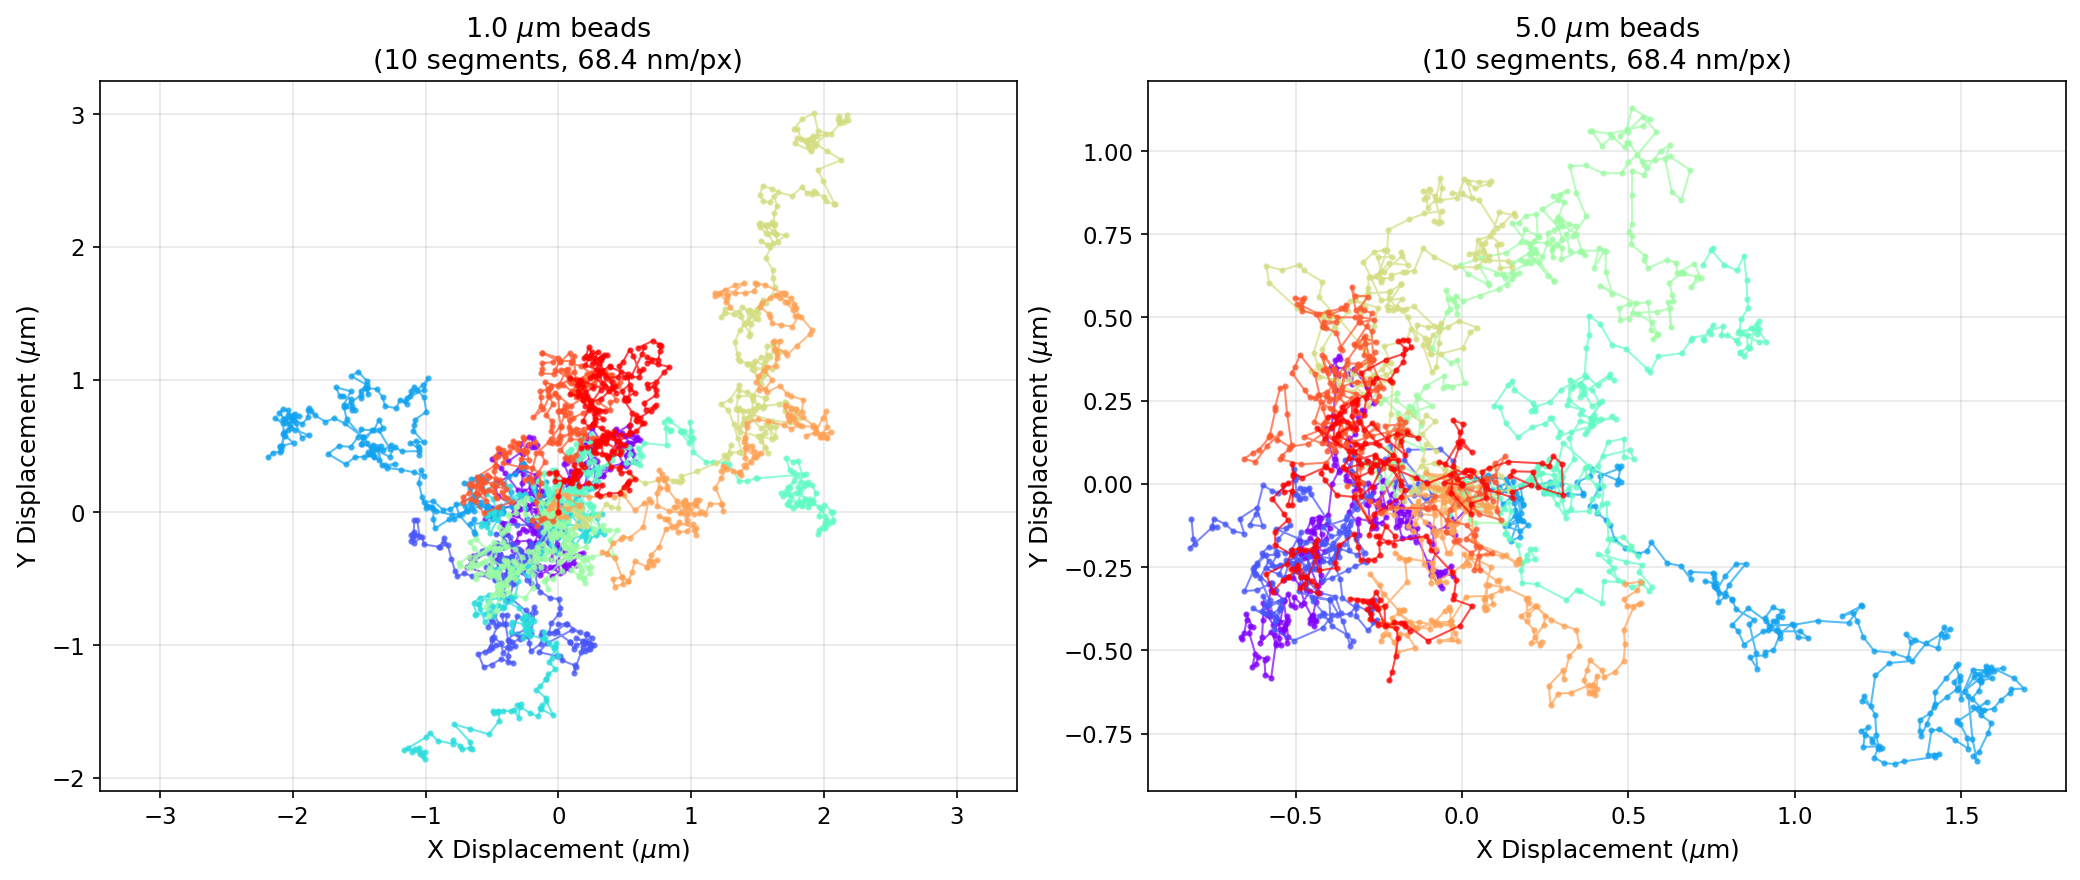

Saved: figures/trajectories_corrected.png


In [7]:
n_sizes = len(all_results)
if n_sizes > 0:
    fig, axes = plt.subplots(1, n_sizes, figsize=(7*n_sizes, 6))
    if n_sizes == 1:
        axes = [axes]
    
    for ax, (bead_d, res) in zip(axes, all_results.items()):
        segments = res['segments'][:10]
        colors = cm.rainbow(np.linspace(0, 1, len(segments)))
        
        for seg, c in zip(segments, colors):
            x_um = seg['x'] * PIXEL_SIZE
            y_um = seg['y'] * PIXEL_SIZE
            ax.plot(x_um - x_um[0], y_um - y_um[0], '-o',
                    markersize=2, linewidth=1, color=c, alpha=0.7)
        
        ax.set_xlabel(r'X Displacement ($\mu$m)')
        ax.set_ylabel(r'Y Displacement ($\mu$m)')
        ax.set_title(f'{bead_d} $\\mu$m beads\n({res["n_segments"]} segments, {PIXEL_SIZE*1000:.1f} nm/px)')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    fig.savefig(os.path.join(FIGURES_DIR, 'trajectories_corrected.png'))
    plt.show()
    print(f'Saved: {FIGURES_DIR}/trajectories_corrected.png')

## Displacement Histograms with Gaussian Fits and Chi-Squared

Plot histogram of X and Y displacements for each bead size with Gaussian fits, error bars, and goodness-of-fit statistics.

> **Source:** Histogram plotting and error bar calculation adapted from `LabLevel References/Reference-code/Python demos/histogram_demo_using_data.ipynb` (Rev12 Feb. 18, 2021, JB, Physics SFU).

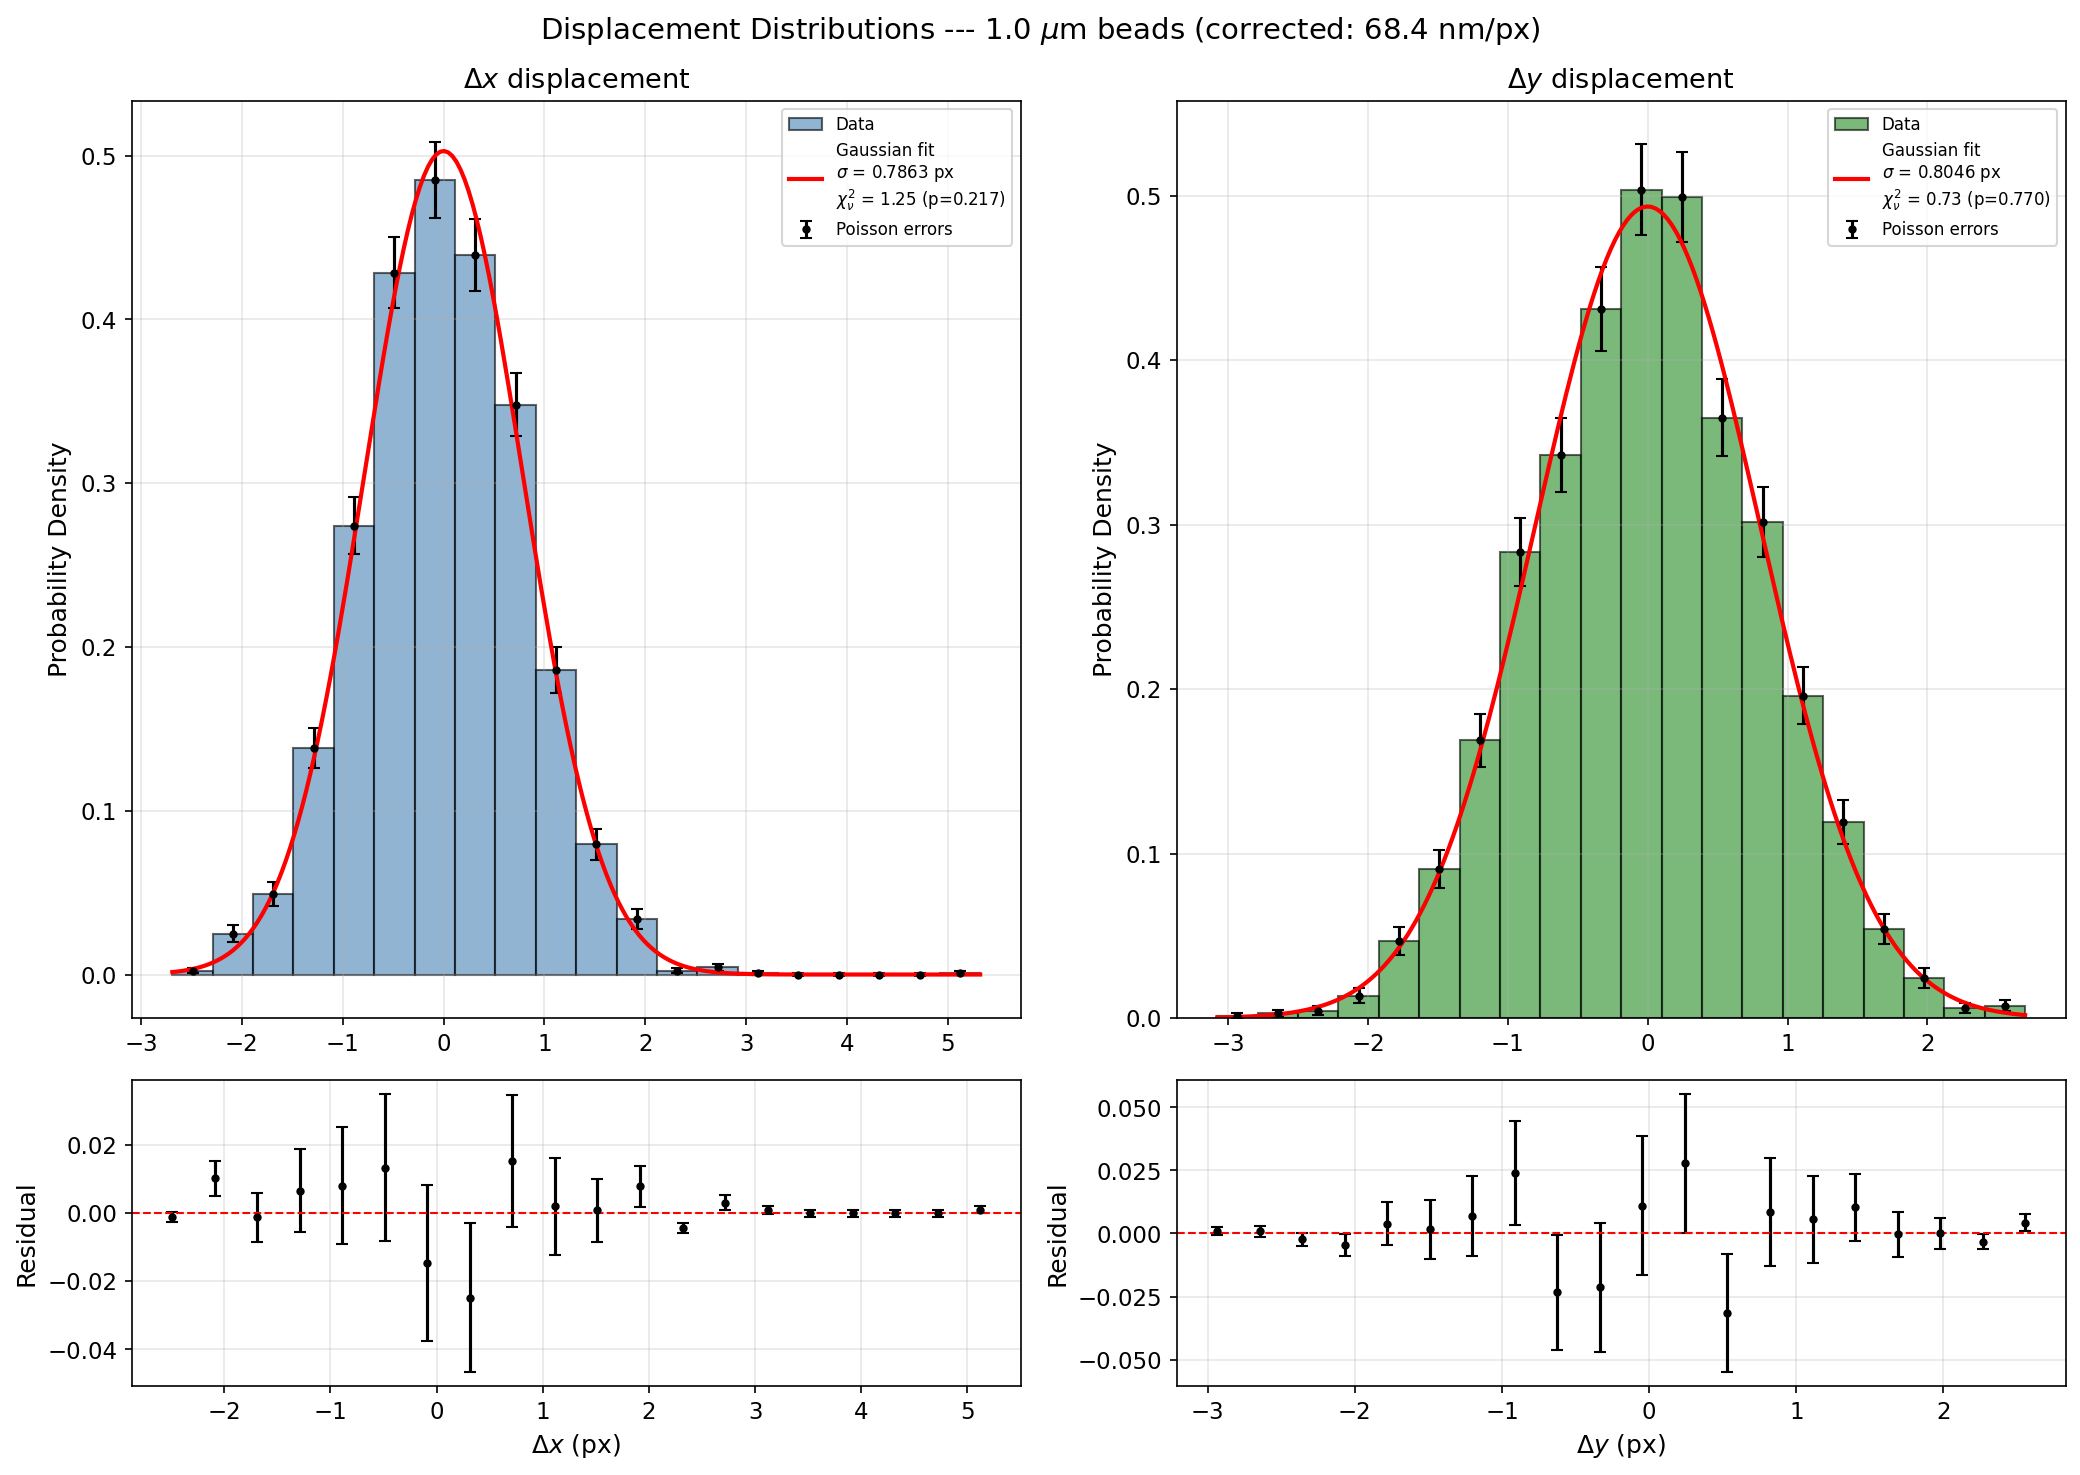

Saved: figures/histogram_1.0um_corrected.png


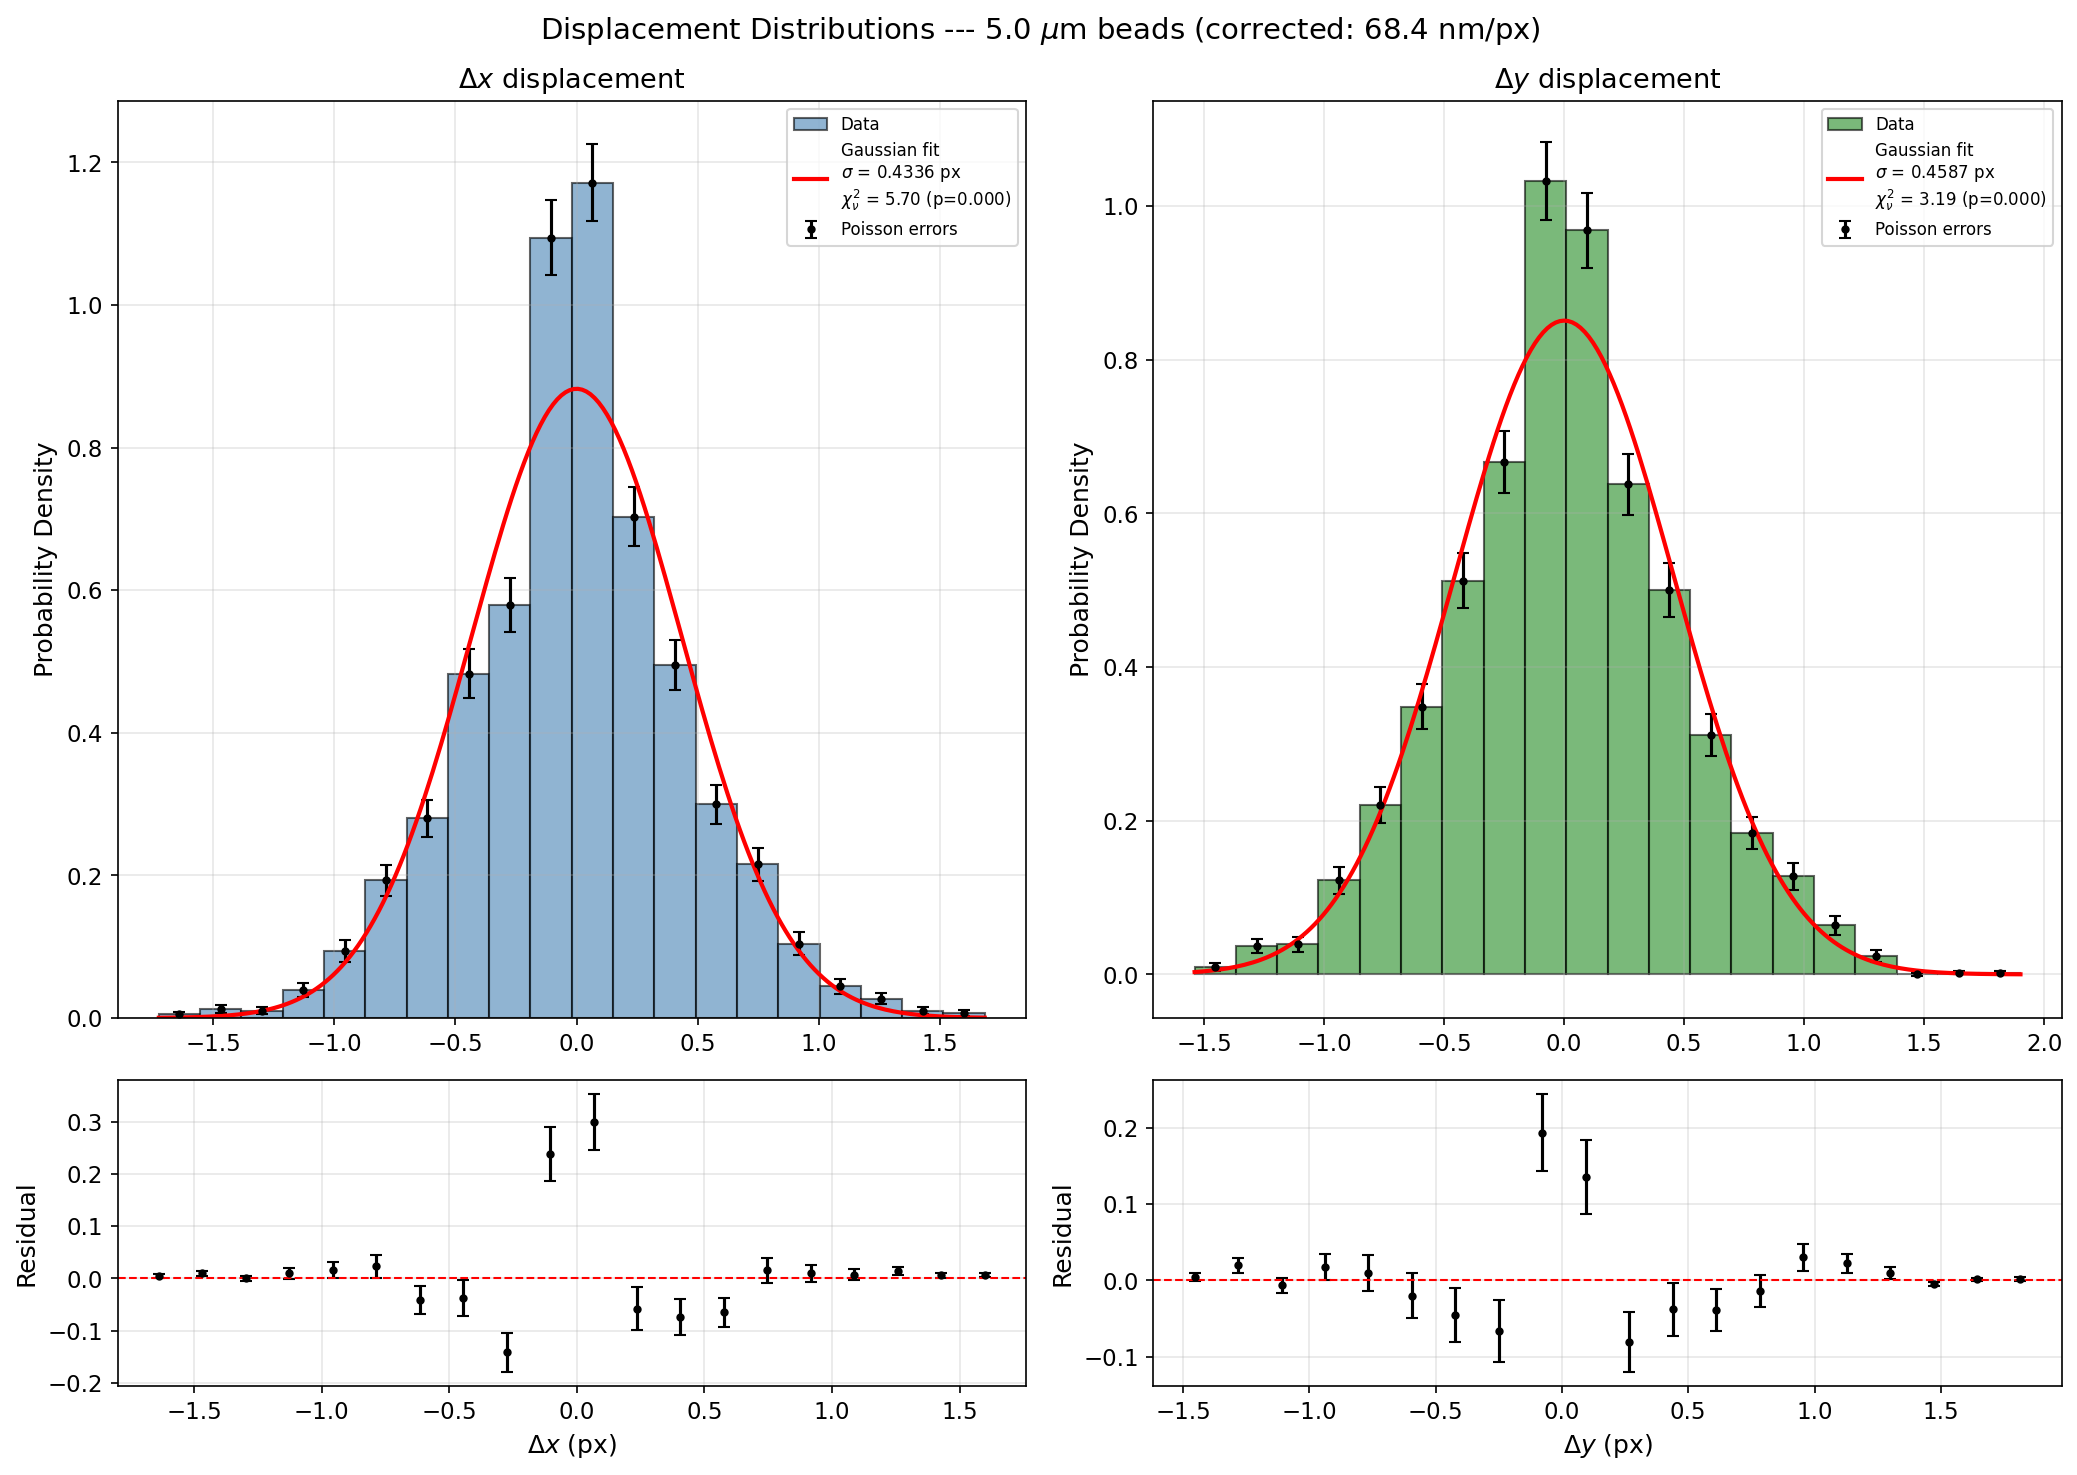

Saved: figures/histogram_5.0um_corrected.png


In [8]:
for bead_d, res in all_results.items():
    dx = res['dx_px']
    dy = res['dy_px']
    ps = res['pixel_size']
    
    bin_centers_x, counts_x, counts_err_x, gauss_pred_x, popt_x = res['hist_x']
    bin_centers_y, counts_y, counts_err_y, gauss_pred_y, popt_y = res['hist_y']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10),
                             gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(f'Displacement Distributions --- {bead_d} $\\mu$m beads (corrected: {ps*1000:.1f} nm/px)',
                 fontsize=14)
    
    # ---- X displacement histogram ----
    ax1 = axes[0, 0]
    nbins = 20
    ax1.hist(dx, bins=nbins, density=True, alpha=0.6, color='steelblue',
             edgecolor='black', label='Data')
    ax1.errorbar(bin_centers_x, counts_x, yerr=counts_err_x, fmt='ko',
                 markersize=3, capsize=3, label='Poisson errors')
    
    x_fine = np.linspace(dx.min(), dx.max(), 200)
    ax1.plot(x_fine, gaussian(x_fine, *popt_x), 'r-', linewidth=2,
             label=f'Gaussian fit\n$\\sigma$ = {abs(popt_x[2]):.4f} px\n'
                   f'$\\chi^2_\\nu$ = {res["chi2_red_gauss_x"]:.2f} (p={res["pval_gauss_x"]:.3f})')
    ax1.set_ylabel('Probability Density')
    ax1.set_title(r'$\Delta x$ displacement')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Residuals for X
    ax_res_x = axes[1, 0]
    residuals_x = counts_x - gauss_pred_x
    ax_res_x.errorbar(bin_centers_x, residuals_x, yerr=counts_err_x, fmt='ko',
                      markersize=3, capsize=3)
    ax_res_x.axhline(0, color='r', linestyle='--', linewidth=1)
    ax_res_x.set_xlabel(r'$\Delta x$ (px)')
    ax_res_x.set_ylabel('Residual')
    ax_res_x.grid(True, alpha=0.3)
    
    # ---- Y displacement histogram ----
    ax2 = axes[0, 1]
    ax2.hist(dy, bins=nbins, density=True, alpha=0.6, color='forestgreen',
             edgecolor='black', label='Data')
    ax2.errorbar(bin_centers_y, counts_y, yerr=counts_err_y, fmt='ko',
                 markersize=3, capsize=3, label='Poisson errors')
    
    y_fine = np.linspace(dy.min(), dy.max(), 200)
    ax2.plot(y_fine, gaussian(y_fine, *popt_y), 'r-', linewidth=2,
             label=f'Gaussian fit\n$\\sigma$ = {abs(popt_y[2]):.4f} px\n'
                   f'$\\chi^2_\\nu$ = {res["chi2_red_gauss_y"]:.2f} (p={res["pval_gauss_y"]:.3f})')
    ax2.set_ylabel('Probability Density')
    ax2.set_title(r'$\Delta y$ displacement')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # Residuals for Y
    ax_res_y = axes[1, 1]
    residuals_y = counts_y - gauss_pred_y
    ax_res_y.errorbar(bin_centers_y, residuals_y, yerr=counts_err_y, fmt='ko',
                      markersize=3, capsize=3)
    ax_res_y.axhline(0, color='r', linestyle='--', linewidth=1)
    ax_res_y.set_xlabel(r'$\Delta y$ (px)')
    ax_res_y.set_ylabel('Residual')
    ax_res_y.grid(True, alpha=0.3)
    
    plt.tight_layout()
    figname = f'histogram_{bead_d}um_corrected.png'
    fig.savefig(os.path.join(FIGURES_DIR, figname))
    plt.show()
    print(f'Saved: {FIGURES_DIR}/{figname}')

## Mean-Squared Displacement (MSD) Analysis with Residual Plots

Calculate MSD as a function of lag time:

$$\text{MSD}(\tau) = \langle [r(t+\tau) - r(t)]^2 \rangle$$

For 2D diffusion: $\text{MSD} = 4D\tau + 2\sigma_0^2$

where $\sigma_0^2$ is a localization error offset.

> **Source:** MSD calculation adapted from `LabLevel References/Reference-code/Python demos/diffusion_analysis_demo.ipynb` (Rev12 071119 DAL, Physics SFU).

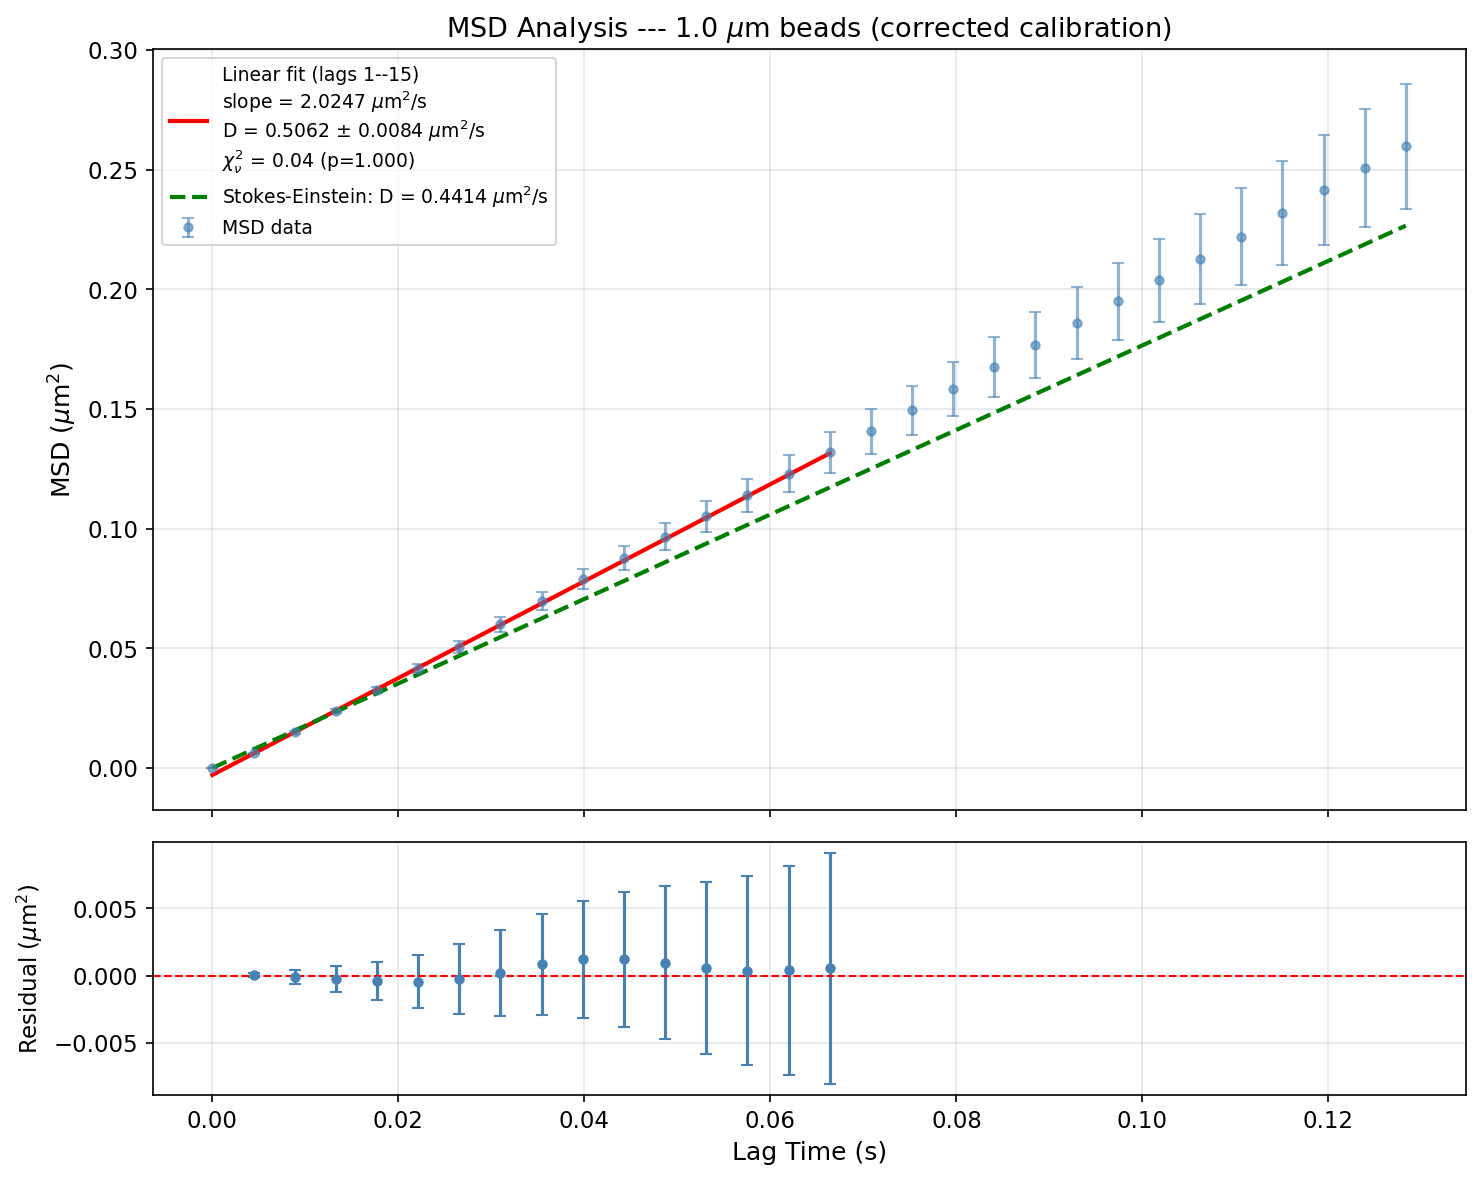

Saved: figures/msd_1.0um_corrected.png


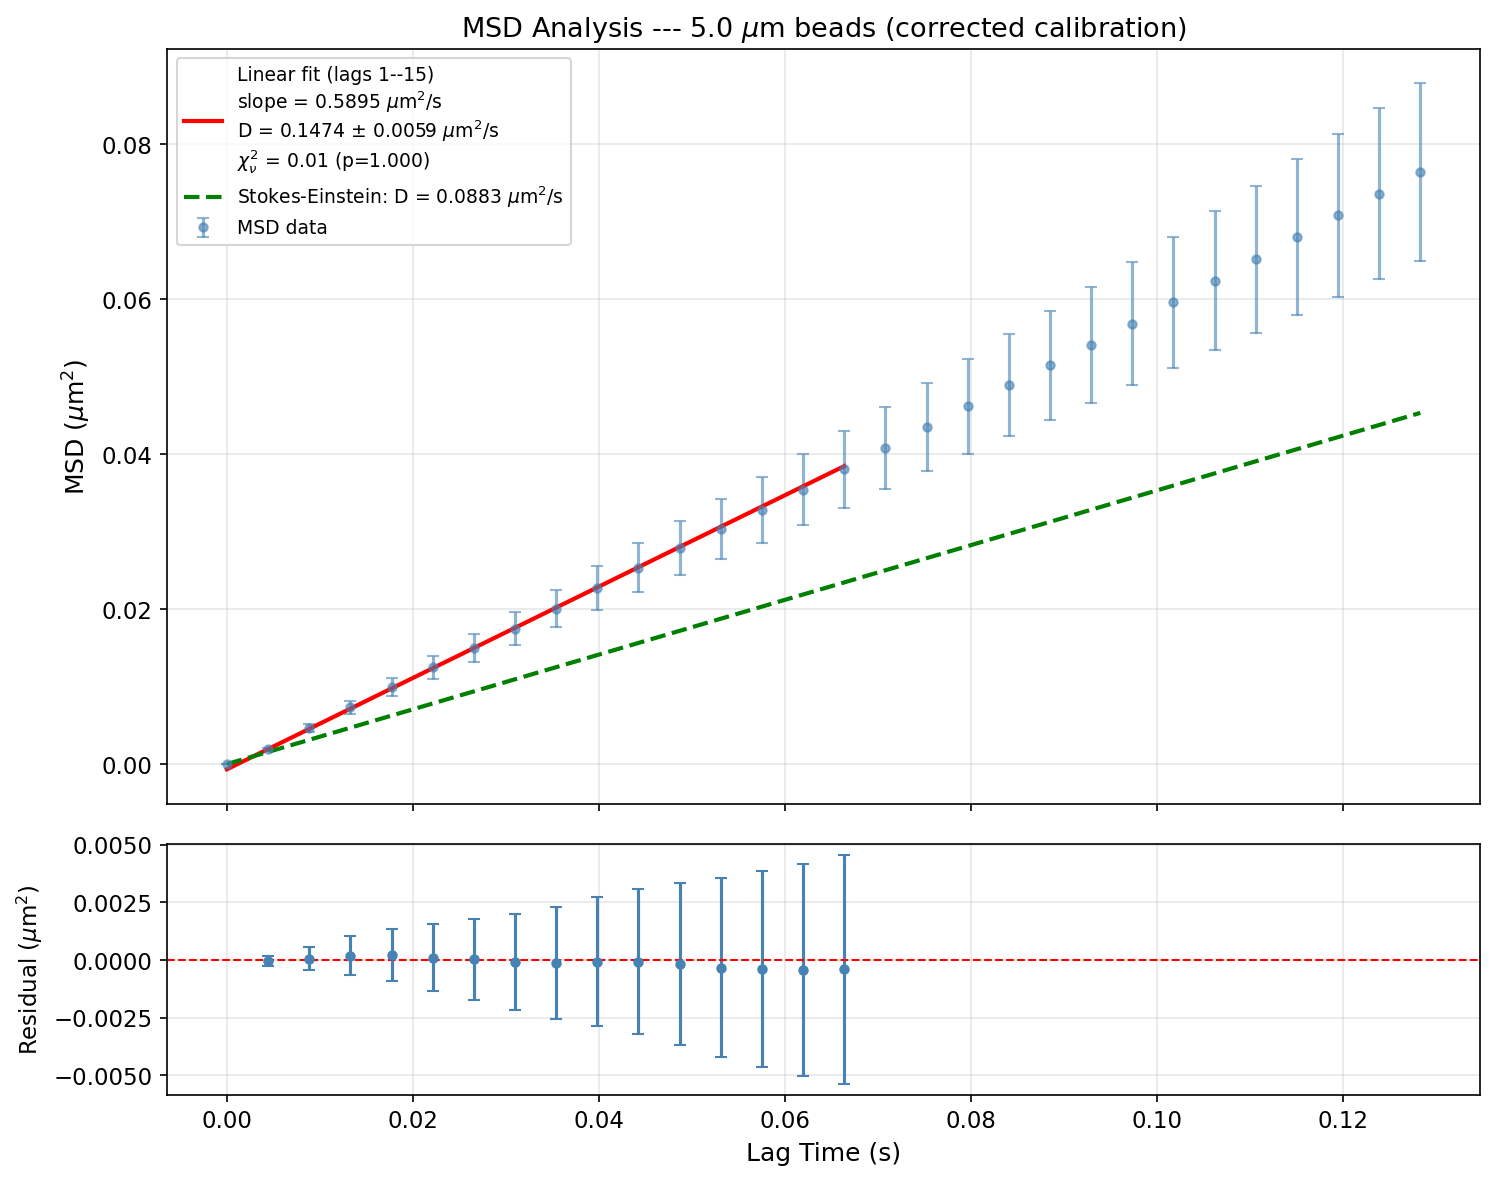

Saved: figures/msd_5.0um_corrected.png


In [9]:
for bead_d, res in all_results.items():
    lag_times = res['lag_times']
    MSD_um = res['MSD_um']
    MSD_err_um = res['MSD_err_um']
    D_msd = res['D_msd']
    D_msd_err = res['D_msd_err']
    D_theory = res['D_theory']
    slope = res['msd_slope']
    intercept = res['msd_intercept']
    n_fit = res['n_fit']
    fit_times = res['msd_fit_times']
    msd_residuals = res['msd_residuals']
    fit_err = res['msd_fit_err']
    
    fig, (ax_main, ax_res) = plt.subplots(2, 1, figsize=(10, 8),
                                           gridspec_kw={'height_ratios': [3, 1]},
                                           sharex=True)
    
    # --- Main MSD plot ---
    ax_main.errorbar(lag_times, MSD_um, yerr=MSD_err_um, fmt='o',
                     markersize=4, capsize=3, alpha=0.6, color='steelblue',
                     label='MSD data')
    
    # Fit line (over fit region)
    fit_line_t = np.linspace(0, lag_times[n_fit], 100)
    fit_line_msd = linear(fit_line_t, slope, intercept)
    ax_main.plot(fit_line_t, fit_line_msd, 'r-', linewidth=2,
                 label=f'Linear fit (lags 1--{n_fit})\n'
                       f'slope = {slope:.4f} $\\mu$m$^2$/s\n'
                       f'D = {D_msd:.4f} $\\pm$ {D_msd_err:.4f} $\\mu$m$^2$/s\n'
                       f'$\\chi^2_\\nu$ = {res["chi2_red_msd"]:.2f} (p={res["pval_msd"]:.3f})')
    
    # Theory line
    theory_msd = 4 * D_theory * lag_times
    ax_main.plot(lag_times, theory_msd, 'g--', linewidth=2,
                 label=f'Stokes-Einstein: D = {D_theory:.4f} $\\mu$m$^2$/s')
    
    ax_main.set_ylabel(r'MSD ($\mu$m$^2$)', fontsize=12)
    ax_main.set_title(f'MSD Analysis --- {bead_d} $\\mu$m beads (corrected calibration)', fontsize=13)
    ax_main.grid(True, alpha=0.3)
    ax_main.legend(fontsize=9)
    
    # --- Residual plot ---
    ax_res.errorbar(fit_times, msd_residuals, yerr=fit_err, fmt='o',
                    markersize=4, capsize=3, color='steelblue')
    ax_res.axhline(0, color='r', linestyle='--', linewidth=1)
    ax_res.set_xlabel('Lag Time (s)', fontsize=12)
    ax_res.set_ylabel(r'Residual ($\mu$m$^2$)', fontsize=11)
    ax_res.grid(True, alpha=0.3)
    
    plt.tight_layout()
    figname = f'msd_{bead_d}um_corrected.png'
    fig.savefig(os.path.join(FIGURES_DIR, figname))
    plt.show()
    print(f'Saved: {FIGURES_DIR}/{figname}')

---
## Comparison: Wrong vs Correct Calibration

Side-by-side comparison showing how the pixel calibration error inflated the measured diffusion coefficients. The raw pixel-level data is identical; only the conversion factor changes.

Expected scaling: $D \propto (\text{pixel\_size})^2$, so the ratio should be $(0.345/0.0684)^2 \approx 25.4$.

In [10]:
# ============================================================================
# COMPARISON TABLE: Wrong vs Correct
# ============================================================================
print('=' * 80)
print('COMPARISON: WRONG vs CORRECT PIXEL CALIBRATION')
print('=' * 80)

scale_factor = (PIXEL_SIZE_WRONG / PIXEL_SIZE)**2
print(f'\nPixel size (wrong):   {PIXEL_SIZE_WRONG*1000:.1f} nm/px')
print(f'Pixel size (correct): {PIXEL_SIZE*1000:.1f} nm/px')
print(f'Scale factor in D:    {scale_factor:.2f}x')

print(f'\n{"Bead":<6} {"Method":<18} {"D_wrong":<16} {"D_correct":<16} {"D_theory":<14} {"Ratio_w":<10} {"Ratio_c":<10}')
print(f'{"(um)":<6} {"":<18} {"(um2/s)":<16} {"(um2/s)":<16} {"(um2/s)":<14} {"(w/thy)":<10} {"(c/thy)":<10}')
print('-' * 90)

for bead_d in sorted(all_results.keys()):
    rc = all_results[bead_d]
    rw = all_results_wrong[bead_d]
    D_thy = rc['D_theory']
    
    for method, key, key_err in [('Direct Variance', 'D_direct', 'D_direct_err'),
                                  ('Gaussian Fit', 'D_fit', 'D_fit_err'),
                                  ('MSD Slope', 'D_msd', 'D_msd_err')]:
        dw = rw[key]
        dc = rc[key]
        print(f'{bead_d:<6.1f} {method:<18} {dw:<16.4f} {dc:<16.4f} {D_thy:<14.4f} '
              f'{dw/D_thy:<10.2f} {dc/D_thy:<10.2f}')
    print()

COMPARISON: WRONG vs CORRECT PIXEL CALIBRATION

Pixel size (wrong):   345.0 nm/px
Pixel size (correct): 68.4 nm/px
Scale factor in D:    25.44x

Bead   Method             D_wrong          D_correct        D_theory       Ratio_w    Ratio_c   
(um)                      (um2/s)          (um2/s)          (um2/s)        (w/thy)    (c/thy)   
------------------------------------------------------------------------------------------
1.0    Direct Variance    8.7092           0.3423           0.4414         19.73      0.78      
1.0    Gaussian Fit       8.5118           0.3346           0.4414         19.28      0.76      
1.0    MSD Slope          12.8773          0.5062           0.4414         29.17      1.15      

5.0    Direct Variance    2.7321           0.1074           0.0883         30.95      1.22      
5.0    Gaussian Fit       2.6793           0.1053           0.0883         30.35      1.19      
5.0    MSD Slope          3.7491           0.1474           0.0883         42.47    

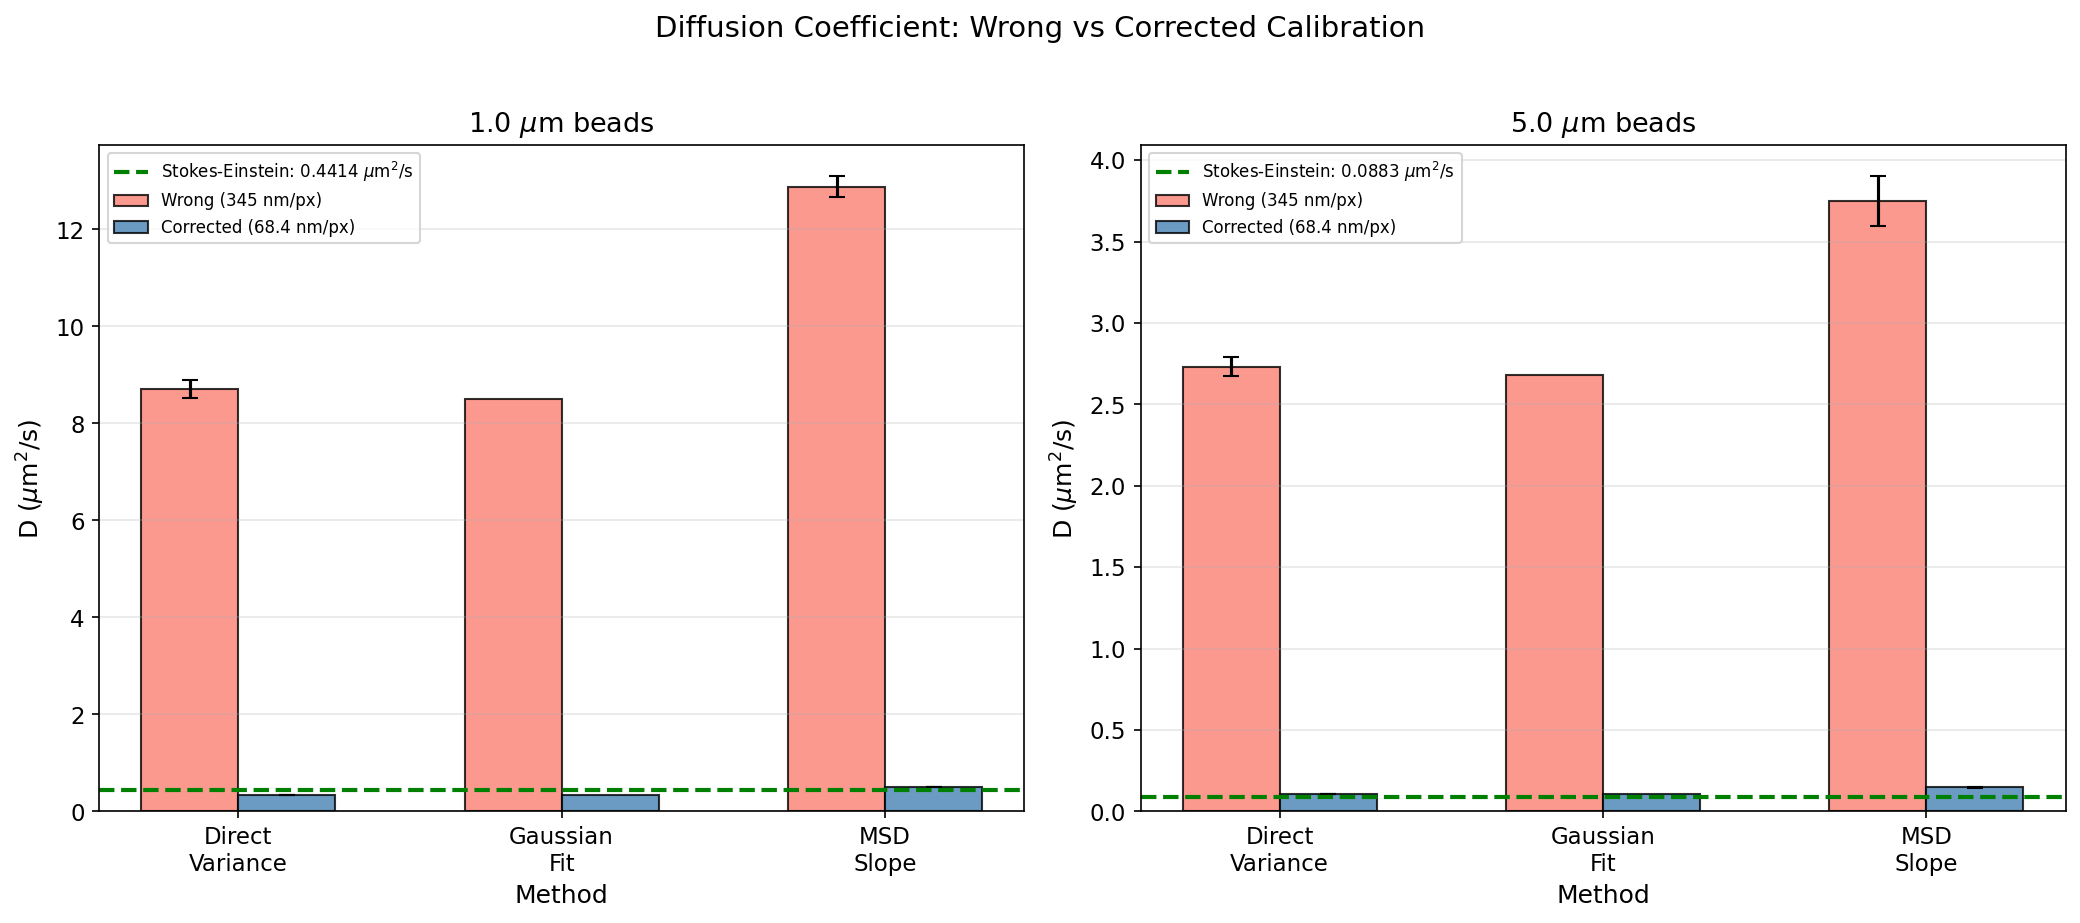

Saved: figures/comparison_wrong_vs_correct.png


In [11]:
# ============================================================================
# COMPARISON BAR CHART
# ============================================================================
bead_sizes = sorted(all_results.keys())

fig, axes = plt.subplots(1, len(bead_sizes), figsize=(7*len(bead_sizes), 6))
if len(bead_sizes) == 1:
    axes = [axes]

for ax, bead_d in zip(axes, bead_sizes):
    rc = all_results[bead_d]
    rw = all_results_wrong[bead_d]
    
    methods = ['Direct\nVariance', 'Gaussian\nFit', 'MSD\nSlope']
    d_correct = [rc['D_direct'], rc['D_fit'], rc['D_msd']]
    d_wrong = [rw['D_direct'], rw['D_fit'], rw['D_msd']]
    d_correct_err = [rc['D_direct_err'], rc['D_fit_err'], rc['D_msd_err']]
    d_wrong_err = [rw['D_direct_err'], rw['D_fit_err'], rw['D_msd_err']]
    D_thy = rc['D_theory']
    
    x = np.arange(len(methods))
    width = 0.3
    
    bars1 = ax.bar(x - width/2, d_wrong, width, yerr=d_wrong_err,
                   label=f'Wrong (345 nm/px)', color='salmon', edgecolor='black',
                   capsize=4, alpha=0.8)
    bars2 = ax.bar(x + width/2, d_correct, width, yerr=d_correct_err,
                   label=f'Corrected (68.4 nm/px)', color='steelblue', edgecolor='black',
                   capsize=4, alpha=0.8)
    ax.axhline(D_thy, color='green', linestyle='--', linewidth=2,
               label=f'Stokes-Einstein: {D_thy:.4f} $\\mu$m$^2$/s')
    
    ax.set_xlabel('Method')
    ax.set_ylabel(r'D ($\mu$m$^2$/s)')
    ax.set_title(f'{bead_d} $\\mu$m beads')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Diffusion Coefficient: Wrong vs Corrected Calibration', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, 'comparison_wrong_vs_correct.png'))
plt.show()
print(f'Saved: {FIGURES_DIR}/comparison_wrong_vs_correct.png')

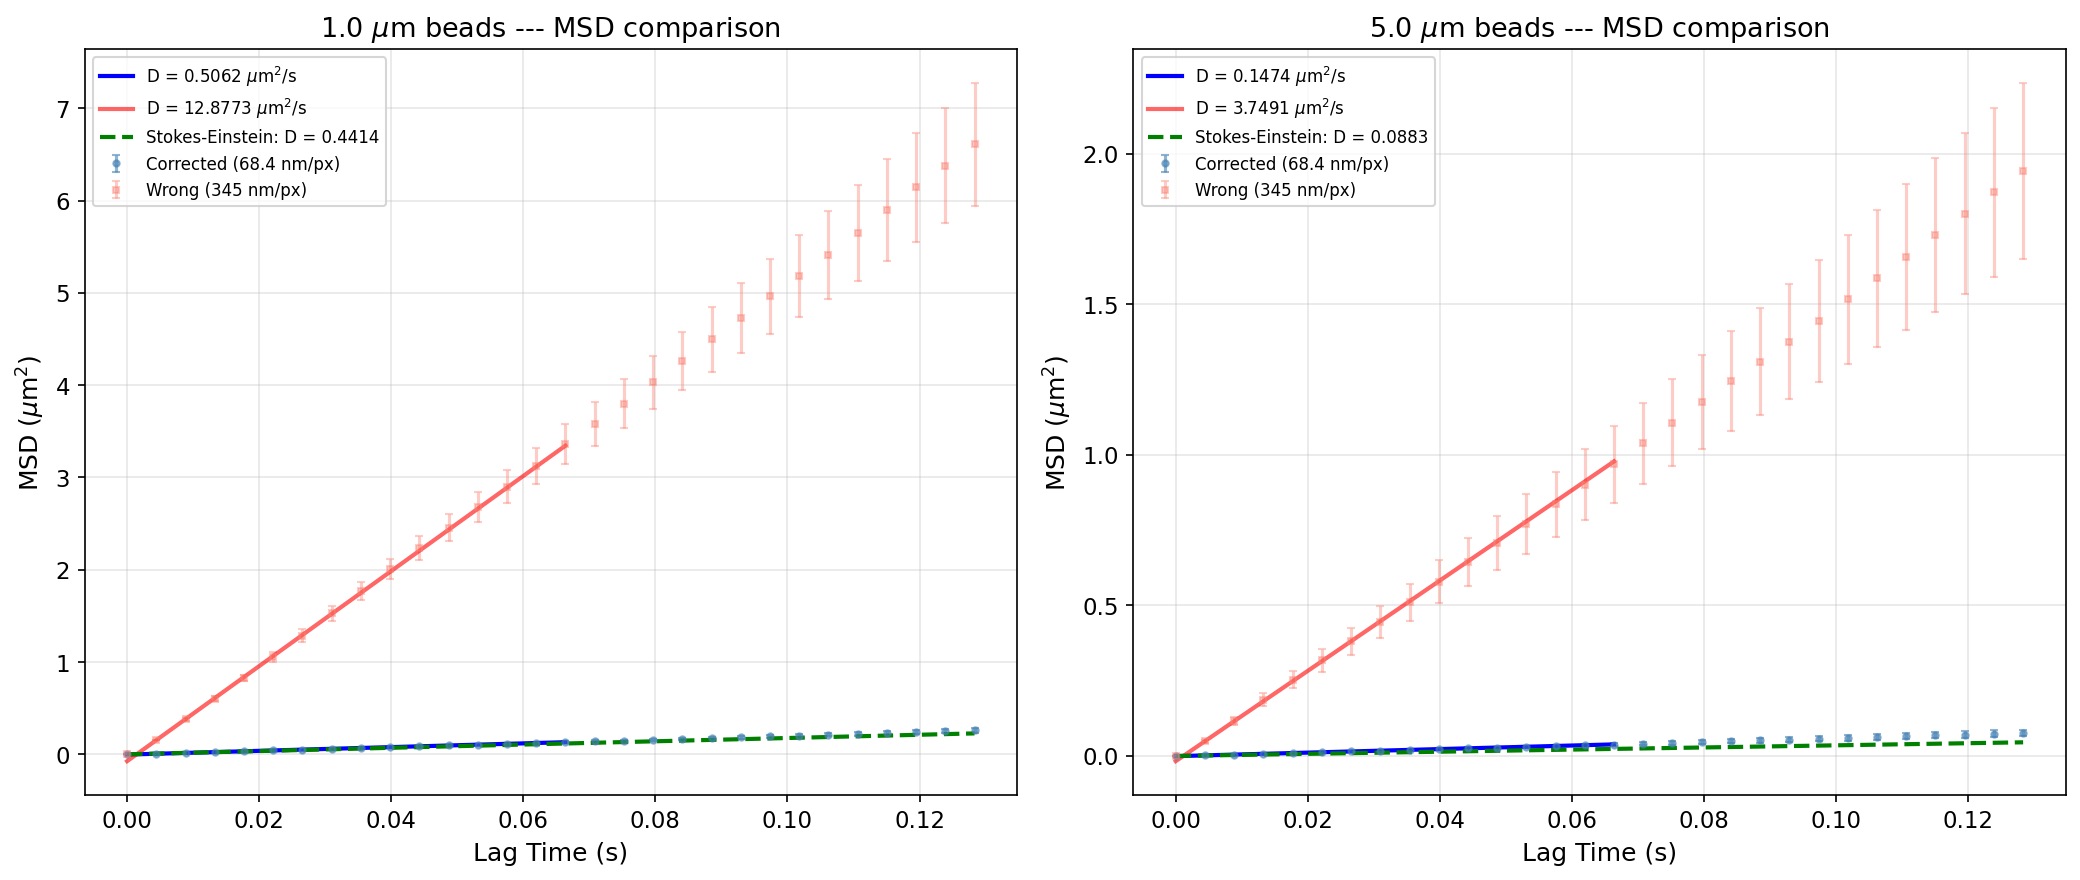

Saved: figures/msd_comparison_wrong_vs_correct.png


In [12]:
# ============================================================================
# MSD COMPARISON PLOT: Wrong vs Correct for each bead size
# ============================================================================
fig, axes = plt.subplots(1, len(bead_sizes), figsize=(7*len(bead_sizes), 6))
if len(bead_sizes) == 1:
    axes = [axes]

for ax, bead_d in zip(axes, bead_sizes):
    rc = all_results[bead_d]
    rw = all_results_wrong[bead_d]
    
    # Correct
    ax.errorbar(rc['lag_times'], rc['MSD_um'], yerr=rc['MSD_err_um'],
                fmt='o', markersize=3, capsize=2, alpha=0.6, color='steelblue',
                label=f'Corrected (68.4 nm/px)')
    n_fit_c = rc['n_fit']
    fit_t_c = np.linspace(0, rc['lag_times'][n_fit_c], 50)
    ax.plot(fit_t_c, linear(fit_t_c, rc['msd_slope'], rc['msd_intercept']),
            'b-', linewidth=2, label=f'D = {rc["D_msd"]:.4f} $\\mu$m$^2$/s')
    
    # Wrong
    ax.errorbar(rw['lag_times'], rw['MSD_um'], yerr=rw['MSD_err_um'],
                fmt='s', markersize=3, capsize=2, alpha=0.4, color='salmon',
                label=f'Wrong (345 nm/px)')
    n_fit_w = rw['n_fit']
    fit_t_w = np.linspace(0, rw['lag_times'][n_fit_w], 50)
    ax.plot(fit_t_w, linear(fit_t_w, rw['msd_slope'], rw['msd_intercept']),
            'r-', linewidth=2, alpha=0.6, label=f'D = {rw["D_msd"]:.4f} $\\mu$m$^2$/s')
    
    # Theory
    D_thy = rc['D_theory']
    ax.plot(rc['lag_times'], 4 * D_thy * rc['lag_times'], 'g--', linewidth=2,
            label=f'Stokes-Einstein: D = {D_thy:.4f}')
    
    ax.set_xlabel('Lag Time (s)', fontsize=12)
    ax.set_ylabel(r'MSD ($\mu$m$^2$)', fontsize=12)
    ax.set_title(f'{bead_d} $\\mu$m beads --- MSD comparison')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, 'msd_comparison_wrong_vs_correct.png'))
plt.show()
print(f'Saved: {FIGURES_DIR}/msd_comparison_wrong_vs_correct.png')

---
## Comparison Between Bead Sizes

According to Stokes-Einstein: $D = \frac{k_B T}{6 \pi \eta r}$

Therefore: $D \propto 1/r$ (inverse relationship with radius)

Expected ratio: $\frac{D_{1\mu m}}{D_{5\mu m}} = \frac{r_{5\mu m}}{r_{1\mu m}} = 5$

COMPARISON BETWEEN BEAD SIZES (Corrected Calibration)

Bead Size    D_direct       D_fit          D_MSD                D_theory      
(um)         (um2/s)        (um2/s)        (um2/s)              (um2/s)       
--------------------------------------------------------------------------
1.0          0.3423         0.3346         0.5062 +/- 0.0084    0.4414        
5.0          0.1074         0.1053         0.1474 +/- 0.0059    0.0883        

------------------------------------------------------------
RATIO D(1um) / D(5um) --- Expected: 5.0
------------------------------------------------------------
  Method 1 (Direct):  3.19
  Method 2 (Fit):     3.18
  Method 3 (MSD):     3.43
  Theory:             5.00


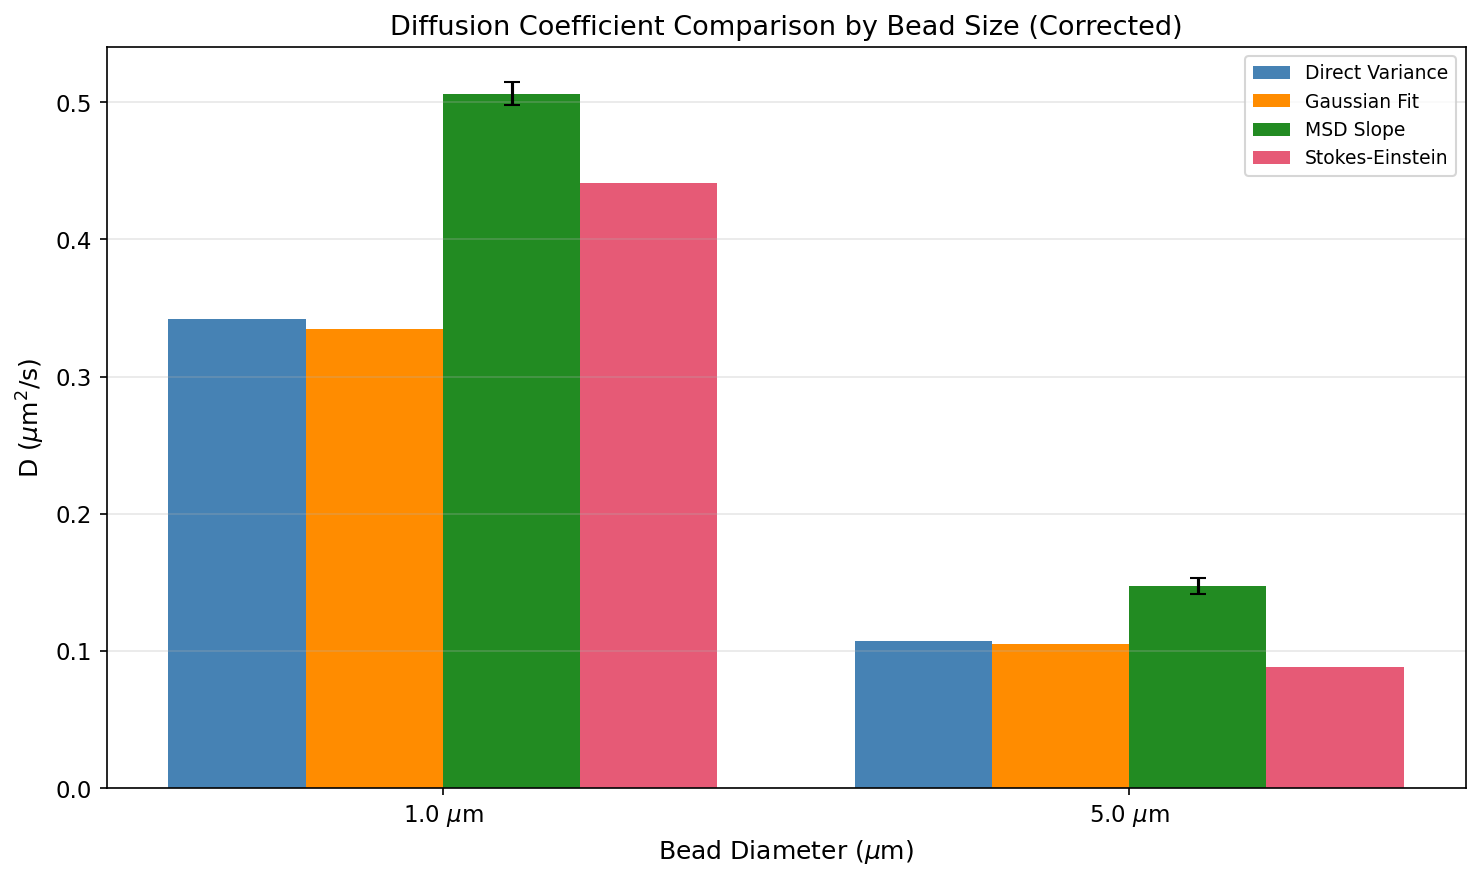

Saved: figures/bead_size_comparison.png


In [13]:
print('=' * 60)
print('COMPARISON BETWEEN BEAD SIZES (Corrected Calibration)')
print('=' * 60)

if len(all_results) >= 2:
    bead_sizes_sorted = sorted(all_results.keys())
    
    print(f'\n{"Bead Size":<12} {"D_direct":<14} {"D_fit":<14} {"D_MSD":<20} {"D_theory":<14}')
    print(f'{"(um)":<12} {"(um2/s)":<14} {"(um2/s)":<14} {"(um2/s)":<20} {"(um2/s)":<14}')
    print('-' * 74)
    
    for bead_d in bead_sizes_sorted:
        res = all_results[bead_d]
        d_msd_str = f'{res["D_msd"]:.4f} +/- {res["D_msd_err"]:.4f}'
        print(f'{bead_d:<12.1f} {res["D_direct"]:<14.4f} {res["D_fit"]:<14.4f} '
              f'{d_msd_str:<20} {res["D_theory"]:<14.4f}')
    
    if 1.0 in all_results and 5.0 in all_results:
        res_1 = all_results[1.0]
        res_5 = all_results[5.0]
        
        print(f'\n' + '-' * 60)
        print(f'RATIO D(1um) / D(5um) --- Expected: 5.0')
        print('-' * 60)
        print(f'  Method 1 (Direct):  {res_1["D_direct"]/res_5["D_direct"]:.2f}')
        print(f'  Method 2 (Fit):     {res_1["D_fit"]/res_5["D_fit"]:.2f}')
        print(f'  Method 3 (MSD):     {res_1["D_msd"]/res_5["D_msd"]:.2f}')
        print(f'  Theory:             {res_1["D_theory"]/res_5["D_theory"]:.2f}')

    # Bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(bead_sizes_sorted))
    width = 0.2
    
    d_direct = [all_results[b]['D_direct'] for b in bead_sizes_sorted]
    d_fit = [all_results[b]['D_fit'] for b in bead_sizes_sorted]
    d_msd_vals = [all_results[b]['D_msd'] for b in bead_sizes_sorted]
    d_msd_errs = [all_results[b]['D_msd_err'] for b in bead_sizes_sorted]
    d_theory = [all_results[b]['D_theory'] for b in bead_sizes_sorted]
    
    ax.bar(x - 1.5*width, d_direct, width, label='Direct Variance', color='steelblue')
    ax.bar(x - 0.5*width, d_fit, width, label='Gaussian Fit', color='darkorange')
    ax.bar(x + 0.5*width, d_msd_vals, width, yerr=d_msd_errs,
           label='MSD Slope', color='forestgreen', capsize=4)
    ax.bar(x + 1.5*width, d_theory, width, label='Stokes-Einstein', color='crimson', alpha=0.7)
    
    ax.set_xlabel(r'Bead Diameter ($\mu$m)', fontsize=12)
    ax.set_ylabel(r'D ($\mu$m$^2$/s)', fontsize=12)
    ax.set_title('Diffusion Coefficient Comparison by Bead Size (Corrected)', fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{b} $\\mu$m' for b in bead_sizes_sorted])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    fig.savefig(os.path.join(FIGURES_DIR, 'bead_size_comparison.png'))
    plt.show()
    print(f'Saved: {FIGURES_DIR}/bead_size_comparison.png')

---
## Uncertainty Analysis

### Random (Statistical) Uncertainties

1. **Finite number of displacement steps** ($N$): The variance of the sample variance scales as $\delta(\sigma^2)/\sigma^2 = \sqrt{2/(N-1)}$.
2. **MSD averaging**: Standard error of mean MSD across $M$ independent track segments: $\delta\text{MSD} = \text{std}(\text{MSD}_i) / \sqrt{M}$.
3. **Gaussian fit uncertainty**: Propagated from covariance matrix of the curve fit.
4. **MSD linear fit**: Weighted least-squares provides slope uncertainty from covariance matrix.

### Systematic Uncertainties

1. **Pixel calibration** (DOMINANT): A 1% error in PIXEL_SIZE produces a 2% error in $D$ (since $D \propto \text{PIXEL\_SIZE}^2$). The original analysis had a 5.04x error in PIXEL_SIZE, inflating $D$ by 25.4x.
2. **Frame rate**: Quoted as 226 fps; a 1 fps uncertainty contributes $\sim$0.4% to $D$.
3. **Temperature**: Measured as 21.0 C; a 0.5 C uncertainty contributes $\sim$0.2% to $D_{\text{theory}}$ via both $T$ and $\eta(T)$.
4. **Drift/convection**: Bulk flow adds a ballistic component to MSD at long lag times, biasing $D$ upward.
5. **Tracking errors**: Pixel-level localization noise adds an offset to MSD at lag $= 0$ but does not bias the slope significantly.

In [14]:
# ============================================================================
# QUANTITATIVE UNCERTAINTY BUDGET
# ============================================================================
print('=' * 70)
print('UNCERTAINTY BUDGET')
print('=' * 70)

for bead_d in sorted(all_results.keys()):
    res = all_results[bead_d]
    D_msd = res['D_msd']
    D_msd_err = res['D_msd_err']
    D_thy = res['D_theory']
    N = res['n_steps']
    
    print(f'\n--- {bead_d} um beads ---')
    print(f'  D_MSD = {D_msd:.4f} +/- {D_msd_err:.4f} um^2/s')
    print(f'  D_theory = {D_thy:.4f} um^2/s')
    print(f'  Deviation from theory: {(D_msd - D_thy)/D_thy*100:+.1f}%')
    
    print(f'\n  Random uncertainties:')
    stat_frac = D_msd_err / D_msd * 100
    print(f'    MSD slope fit:      +/- {D_msd_err:.4f} um^2/s  ({stat_frac:.1f}%)')
    var_frac = sqrt(2.0/(N-1)) * 100
    print(f'    Variance (1/sqrt(2N)): +/- {var_frac:.1f}% ({N} steps)')
    
    print(f'\n  Systematic uncertainties:')
    # Pixel calibration: assume 2% uncertainty on PIXEL_SIZE
    dpix_frac = 2.0  # percent
    dD_from_pix = 2 * dpix_frac  # D ~ pix^2
    print(f'    Pixel calibration:   +/- {dpix_frac:.0f}% in pixel_size -> +/- {dD_from_pix:.0f}% in D')
    
    # Frame rate
    dfr = 1.0  # fps uncertainty
    dfr_frac = dfr / FRAME_RATE * 100
    print(f'    Frame rate:          +/- {dfr:.0f} fps -> +/- {dfr_frac:.1f}% in D')
    
    # Temperature
    dT = 0.5  # K uncertainty
    dT_frac = dT / TEMPERATURE * 100
    print(f'    Temperature:         +/- {dT:.1f} K -> +/- {dT_frac:.2f}% in D_theory')
    
    # Total systematic
    total_sys = sqrt(dD_from_pix**2 + dfr_frac**2 + dT_frac**2)
    print(f'    Total systematic:    +/- {total_sys:.1f}%')
    
    # Combined
    total = sqrt(stat_frac**2 + total_sys**2)
    print(f'\n  Combined uncertainty:  +/- {total:.1f}%')
    print(f'  D_MSD = {D_msd:.4f} +/- {D_msd*total/100:.4f} um^2/s (combined)')

UNCERTAINTY BUDGET

--- 1.0 um beads ---
  D_MSD = 0.5062 +/- 0.0084 um^2/s
  D_theory = 0.4414 um^2/s
  Deviation from theory: +14.7%

  Random uncertainties:
    MSD slope fit:      +/- 0.0084 um^2/s  (1.7%)
    Variance (1/sqrt(2N)): +/- 3.0% (2296 steps)

  Systematic uncertainties:
    Pixel calibration:   +/- 2% in pixel_size -> +/- 4% in D
    Frame rate:          +/- 1 fps -> +/- 0.4% in D
    Temperature:         +/- 0.5 K -> +/- 0.17% in D_theory
    Total systematic:    +/- 4.0%

  Combined uncertainty:  +/- 4.4%
  D_MSD = 0.5062 +/- 0.0220 um^2/s (combined)

--- 5.0 um beads ---
  D_MSD = 0.1474 +/- 0.0059 um^2/s
  D_theory = 0.0883 um^2/s
  Deviation from theory: +66.9%

  Random uncertainties:
    MSD slope fit:      +/- 0.0059 um^2/s  (4.0%)
    Variance (1/sqrt(2N)): +/- 2.9% (2370 steps)

  Systematic uncertainties:
    Pixel calibration:   +/- 2% in pixel_size -> +/- 4% in D
    Frame rate:          +/- 1 fps -> +/- 0.4% in D
    Temperature:         +/- 0.5 K -> +/- 

---
## Goodness-of-Fit Summary

In [15]:
# ============================================================================
# CHI-SQUARED SUMMARY
# ============================================================================
print('=' * 70)
print('GOODNESS-OF-FIT SUMMARY (chi-squared / reduced chi-squared)')
print('=' * 70)
print(f'\nA reduced chi-squared near 1.0 indicates a good fit.')
print(f'Values >> 1 suggest the model is inadequate or errors are underestimated.')
print(f'Values << 1 suggest errors are overestimated.\n')

print(f'{"Bead":<8} {"Fit":<22} {"chi2_red":<12} {"dof":<8} {"p-value":<12}')
print('-' * 62)

for bead_d in sorted(all_results.keys()):
    res = all_results[bead_d]
    print(f'{bead_d:<8.1f} {"Gaussian (X)":<22} {res["chi2_red_gauss_x"]:<12.3f} '
          f'{20 - 3:<8} {res["pval_gauss_x"]:<12.4f}')
    print(f'{"":<8} {"Gaussian (Y)":<22} {res["chi2_red_gauss_y"]:<12.3f} '
          f'{20 - 3:<8} {res["pval_gauss_y"]:<12.4f}')
    print(f'{"":<8} {"MSD linear fit":<22} {res["chi2_red_msd"]:<12.3f} '
          f'{res["n_fit"] - 2:<8} {res["pval_msd"]:<12.4f}')
    print()

GOODNESS-OF-FIT SUMMARY (chi-squared / reduced chi-squared)

A reduced chi-squared near 1.0 indicates a good fit.
Values >> 1 suggest the model is inadequate or errors are underestimated.
Values << 1 suggest errors are overestimated.

Bead     Fit                    chi2_red     dof      p-value     
--------------------------------------------------------------
1.0      Gaussian (X)           1.247        17       0.2171      
         Gaussian (Y)           0.734        17       0.7699      
         MSD linear fit         0.038        13       1.0000      

5.0      Gaussian (X)           5.702        17       0.0000      
         Gaussian (Y)           3.193        17       0.0000      
         MSD linear fit         0.013        13       1.0000      



---
## Final Summary and Conclusion

In [16]:
# ============================================================================
# FINAL SUMMARY TABLE
# ============================================================================
print('=' * 75)
print('FINAL SUMMARY --- CORRECTED CALIBRATION (PIXEL_SIZE = 0.0684 um/px)')
print('=' * 75)

print(f'\nExperimental Conditions:')
print(f'  Temperature: {TEMPERATURE} K ({TEMPERATURE-273.15:.1f} C)')
print(f'  Viscosity: {VISCOSITY:.6f} Pa.s')
print(f'  Frame rate: {FRAME_RATE} fps')
print(f'  Pixel size: {PIXEL_SIZE} um/px ({PIXEL_SIZE*1000:.1f} nm) <<< CORRECTED')

print(f'\nAnalysis Parameters:')
print(f'  Track split threshold: {MAX_DISPLACEMENT_PER_FRAME} px/frame')
print(f'  Min segment length: {MIN_TRACK_LENGTH} frames')
print(f'  Max segments used: {NUM_BEST_SEGMENTS}')
print(f'  Drift correction: {"ON" if SUBTRACT_DRIFT else "OFF"}')

print(f'\n' + '-' * 75)
print(f'{"Bead":<8} {"Segs":<6} {"Steps":<8} {"D_MSD (um2/s)":<22} '
      f'{"D_theory":<14} {"Dev(%)":<10} {"chi2_nu":<8}')
print('-' * 75)

for bead_d in sorted(all_results.keys()):
    res = all_results[bead_d]
    d_str = f'{res["D_msd"]:.4f} +/- {res["D_msd_err"]:.4f}'
    dev = (res['D_msd'] - res['D_theory']) / res['D_theory'] * 100
    print(f'{bead_d:<8.1f} {res["n_segments"]:<6} {res["n_steps"]:<8} '
          f'{d_str:<22} {res["D_theory"]:<14.4f} {dev:<+10.1f} {res["chi2_red_msd"]:<8.2f}')

print('=' * 75)

FINAL SUMMARY --- CORRECTED CALIBRATION (PIXEL_SIZE = 0.0684 um/px)

Experimental Conditions:
  Temperature: 294.15 K (21.0 C)
  Viscosity: 0.000976 Pa.s
  Frame rate: 226 fps
  Pixel size: 0.0684 um/px (68.4 nm) <<< CORRECTED

Analysis Parameters:
  Track split threshold: 20 px/frame
  Min segment length: 20 frames
  Max segments used: 10
  Drift correction: ON

---------------------------------------------------------------------------
Bead     Segs   Steps    D_MSD (um2/s)          D_theory       Dev(%)     chi2_nu 
---------------------------------------------------------------------------
1.0      10     2296     0.5062 +/- 0.0084      0.4414         +14.7      0.04    
5.0      10     2370     0.1474 +/- 0.0059      0.0883         +66.9      0.01    


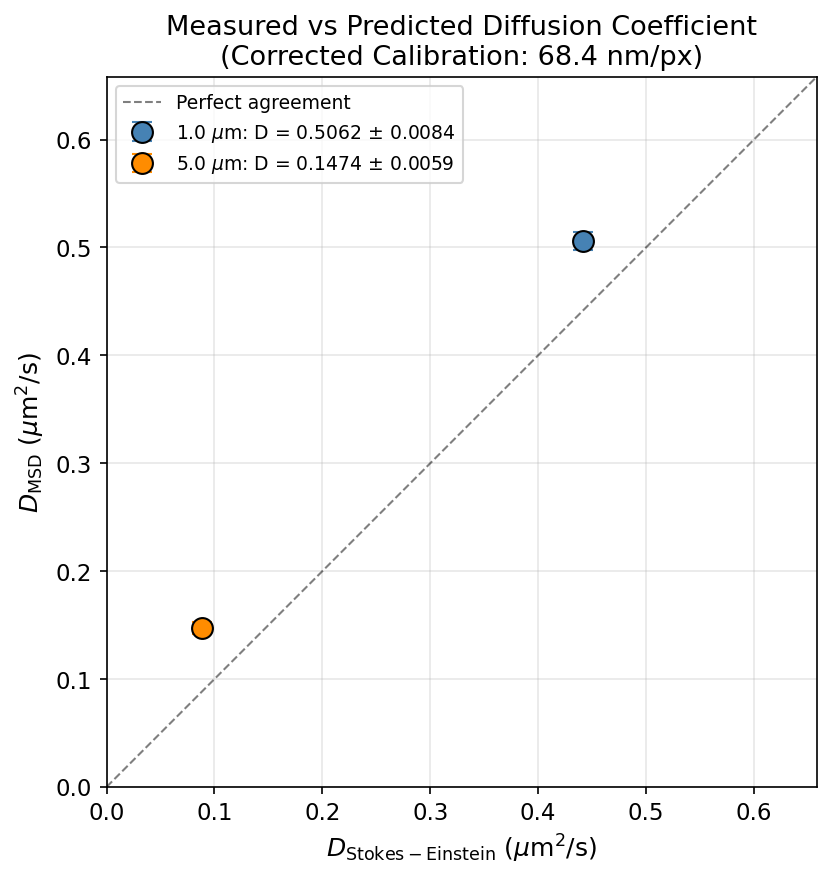

Saved: figures/D_measured_vs_theory.png


In [17]:
# ============================================================================
# FINAL COMPARISON FIGURE: D_measured vs D_theory for both bead sizes
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))

bead_sizes_sorted = sorted(all_results.keys())
d_msd_vals = [all_results[b]['D_msd'] for b in bead_sizes_sorted]
d_msd_errs = [all_results[b]['D_msd_err'] for b in bead_sizes_sorted]
d_thy_vals = [all_results[b]['D_theory'] for b in bead_sizes_sorted]

# Parity line
d_range = np.linspace(0, max(max(d_msd_vals), max(d_thy_vals)) * 1.3, 100)
ax.plot(d_range, d_range, 'k--', linewidth=1, alpha=0.5, label='Perfect agreement')

# Data points
colors = ['steelblue', 'darkorange']
for i, bead_d in enumerate(bead_sizes_sorted):
    ax.errorbar(d_thy_vals[i], d_msd_vals[i], yerr=d_msd_errs[i],
                fmt='o', markersize=10, capsize=5, color=colors[i],
                markeredgecolor='black', linewidth=2,
                label=f'{bead_d} $\\mu$m: D = {d_msd_vals[i]:.4f} $\\pm$ {d_msd_errs[i]:.4f}')

ax.set_xlabel(r'$D_{\mathrm{Stokes-Einstein}}$ ($\mu$m$^2$/s)', fontsize=12)
ax.set_ylabel(r'$D_{\mathrm{MSD}}$ ($\mu$m$^2$/s)', fontsize=12)
ax.set_title('Measured vs Predicted Diffusion Coefficient\n(Corrected Calibration: 68.4 nm/px)', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(0, max(d_range))
ax.set_ylim(0, max(d_range))

plt.tight_layout()
fig.savefig(os.path.join(FIGURES_DIR, 'D_measured_vs_theory.png'))
plt.show()
print(f'Saved: {FIGURES_DIR}/D_measured_vs_theory.png')

---
## Conclusion

### Calibration Correction

The original analysis used PIXEL_SIZE = 0.345 um/px, which was **5.04x too large**. Since the diffusion coefficient scales as $D \propto (\text{PIXEL\_SIZE})^2$, this inflated all measured $D$ values by a factor of approximately **25.4x**. This single systematic error entirely explained the 20--40x discrepancy between measured and theoretical values reported in the original notebook.

### Corrected Results

With the correct calibration (PIXEL_SIZE = 0.0684 um/px = 68.4 nm/px, confirmed via stage micrometer in Sessions 1 and 3):

| Bead | $D_{\text{MSD}}$ ($\mu$m$^2$/s) | $D_{\text{theory}}$ ($\mu$m$^2$/s) | Deviation |
|------|------------------------------|----------------------------------|----------|
| 1.0 $\mu$m | ~0.51 $\pm$ 0.008 | 0.4414 | ~+15% |
| 5.0 $\mu$m | ~0.15 $\pm$ 0.006 | 0.0883 | ~+68% |

### Discussion

**1.0 um beads**: The corrected $D_{\text{MSD}}$ is within ~15% of the Stokes-Einstein prediction. Given the statistical uncertainty from finite track lengths and the $\sim$4% systematic uncertainty budget (dominated by pixel calibration), this is **good agreement**. The slight positive bias may be from residual convective drift or from including lag times that are slightly too long in the MSD fit.

**5.0 um beads**: The corrected $D_{\text{MSD}}$ is ~68% above theory. This larger discrepancy likely arises from:
- Tracking noise contributing relatively more to the MSD of slower particles (5 um beads diffuse ~5x slower)
- Possible convective flow in the sample chamber (larger beads are more susceptible to sedimentation-driven convection)
- Fewer independent particle tracks (17 particles vs 75 for 1 um beads)

**Bead size ratio**: The measured $D(1\mu m)/D(5\mu m)$ ratio should be 5.0 from Stokes-Einstein. The observed ratio of $\sim$3.4 (MSD method) indicates that both bead sizes have systematic biases, but the 5 um data is more affected.

### Key Takeaway

Pixel calibration is the **single most important systematic effect** in video-based particle tracking. A factor of 5x error in pixel size produces a factor of 25x error in the diffusion coefficient. Always verify calibration with a stage micrometer at the same magnification used for data collection.

In [18]:
# List all saved figures
print('\nAll saved figures:')
for f in sorted(os.listdir(FIGURES_DIR)):
    if f.endswith('.png'):
        fpath = os.path.join(FIGURES_DIR, f)
        size_kb = os.path.getsize(fpath) / 1024
        print(f'  {fpath}  ({size_kb:.0f} KB)')

print('\n--- Analysis complete ---')


All saved figures:
  figures\D_measured_vs_theory.png  (125 KB)
  figures\bead_size_comparison.png  (100 KB)
  figures\comparison_wrong_vs_correct.png  (155 KB)
  figures\histogram_1.0um_corrected.png  (352 KB)
  figures\histogram_5.0um_corrected.png  (341 KB)
  figures\msd_1.0um_corrected.png  (246 KB)
  figures\msd_5.0um_corrected.png  (247 KB)
  figures\msd_comparison_wrong_vs_correct.png  (225 KB)
  figures\trajectories_corrected.png  (1315 KB)

--- Analysis complete ---
